# A study of Monte Carlo simulation in option pricing

## Introduction

This project takes a look at how option pricing with Monte Carlo works with the main focus being the numerical and computational aspects of this problem and methods of improving efficiency of Monte Carlo simulations. It will not go into deep detail on the underlying stochastic analysis of derivatives pricing, some results might be quoted, and no arbitrage is assumed. Comparisons between basic crude Monte Carlo and control variate processes with their impact on variance and computation time will be made. The contract types studied are basic European options and Asian options on the S&P 500 index.   

The project is written in Python, and the following libraries and modules as used:

numpy

pandas

time

matplotlib

scipy

For comparison of computational speed Fortran (f90 standard) is also used with multithreading using OpenMP by wrapping the code into a Python module using F2PY. Since this is a jupyter notebook project, the wrapping is done with fortranmagic (https://github.com/mgaitan/fortran_magic). The Fortran translation of the Mersenne Twister random number generator from C was written by Hiroshi Takano and augmented by many, the full list of contributors and copyright declarations are presented at the end.


## Monte Carlo simulation

The basic idea of Monte Carlo simulation in this context is to evaluate expectation values by drawing random samples from the underlying distribution of the quantity of interest and calculating their average. This average is a good unbiased estimator of the expectation value thanks to the Law of Large Numbers. The error of the estimator can be evaluated as follows: let $f$ be the quantity of whose expectation value is of interest, then the estimator of the expectation value (denoted with a hat) is

\begin{alignat}{1}
\hat{\mathbb{E}}[f] = \dfrac{\sum_i^n f_i}{n},
\end{alignat}

and as the variance of this estimator one gets

\begin{alignat}{2}
&\text{Var}(\hat{\mathbb{E}}[f]) &&= \text{Var}\left(\dfrac{\sum_i^n f_i}{n}\right)=\mathbb{E}\left[\left(\dfrac{\sum_i^n f_i}{n}-\mathbb{E}\left[\dfrac{\sum_i^n f_i}{n}\right]\right)^2\right]=\dfrac{1}{n^2}\text{Var}\left(\sum_i^n f_i\right) = \dfrac{1}{n^2}\left(\sum_i^n\text{Var}(f_i)-2\sum_{i\neq j}^n\text{Cov}(f_i,f_j)\right) \nonumber \\
& &&= \dfrac{1}{n^2}n\text{Var}(f)=\frac{\sigma^2}{n},
\end{alignat}

where the independence of samples $f_i$ is assumed. The standard error of the estimator $\hat{\mathbb{E}}(f)$ is defined as 

\begin{alignat}{1}
\sigma_{\hat{\mathbb{E}}} = \dfrac{\sigma}{\sqrt{n}} \approx \dfrac{s}{\sqrt{n}},
\end{alignat}

where $\sigma$ is the population standard deviation of the underlying quantity and $s$ is the sample standard deviation. The approximation in $(3)$ is usually needed since the population variance is not necessarily known. The standard error is the standard deviation of the sampling distribution and is a good metric in estimating the error of the Monte Carlo estimator. Because of the $n^{-1/2}$ convergence of the error, it is usually more practical from a computational point of view to try and reduce the sample standard deviation than add more simulation steps when attempting to reduce error. 

The distribution from which random samples are drawn is dependent on the system under study and the variance and error  reduction schemes employed are chosen keeping this in mind. 

## Brownian motion and the Black-Scholes equation

### Brownian motion

Standard Brownian motion $W(t)$ is a continuous time stochastic process that has the following properties:

\begin{alignat}{1}
& W(0) = 0, \\
& W(t) \text{ is continuous in $t$ with probability 1}, \\
& W(t)-W(s) \sim \mathcal{N}(0,t-s), \text{for any $0\leqslant s\leqslant t$},
\end{alignat}

It follows from $(5)$ and $(6)$ that for a mapping $t \rightarrow [0,T]$ 

\begin{alignat}{1}
W(t) \sim \mathcal{N}(0,t), \text{ for $0\leqslant t\leqslant T$}.
\end{alignat}

A process $X(t)$ is a Brownian motion with drift $\mu$ and diffusion $\sigma^2$, denoted by $X(t) \sim BM(\mu,\sigma^2)$ where $\sigma>0$, if 

\begin{alignat}{1}
W(t) = \dfrac{X(t)-\mu t}{\sigma},
\end{alignat}

from which it can be seen how to construct a $X(t)$ from the standard Brownian motion. Moreover an Ito process $X(t)$ solves the SDE

\begin{alignat}{1}
dX(t) = \mu dt + \sigma dW(t),
\end{alignat}

and has the distribution $X(t) \sim \mathcal{N}(\mu t, \sigma^2 t)$. For the purposes of this investigation described above the parameters $\mu$ and $\sigma$ are kept constant for most of the simulations, even though in they need not be.

### Black-Scholes stock price dynamics and solution for European Call option

Denoting the price of the stock underlying an option as an Ito process $S(t)$, the evolution of the stock price in the Black-Scholes model is described by the SDE

\begin{alignat}{1}
dS(t) = \mu S(t)dt+\sigma S(t)dW(t),
\end{alignat}

where $W(t)$ is a standard Brownian motion described above. Since both $\mu$ and $\sigma$ are kept constant, solution for $(7)$, assuming $S(t)\neq 0 $ for all $0 \leqslant t \leqslant T$ in the interval $[0,T]$ can be obtained from 

\begin{alignat}{1}
dS(t) &= \mu S(t)dt+\sigma S(t)dW(t) \\ 
\Leftrightarrow \dfrac{dS(t)}{S(t)} &= \mu dt+\sigma dW(t). 
\end{alignat}

Now $(11)$ is usually solved by first noting that $(12)$ looks like the derivative of a logarithm and then implementing Ito's lemma on $f(S(t))=\ln(S(t))$:

\begin{alignat}{2}
df(S(t)) &=&& \dfrac{\partial f(S(t))}{\partial S(t)}dS(t)+\dfrac{1}{2}\dfrac{\partial^2 f(S(t))}{\partial S(t)^2}dS(t)^2 \\
&=&& \dfrac{1}{S(t)}dS(t)-\dfrac{1}{2}\dfrac{1}{S(t)^2}dS(t)^2 \\
&=&& \dfrac{\mu S(t)dt+\sigma S(t)dW(t)}{S(t)}-\dfrac{1}{2}\dfrac{\sigma^2 S(t)^2dW(t)^2}{S(t)^2} \\
&=&& \left(\mu-\dfrac{\sigma^2}{2}\right)dt+\sigma dW(t),
\end{alignat}

where quadratic variation $dW(t)^2=dt$ was used for the last step. Integrating both sides of $(12)$ gives

\begin{alignat}{2}
\int_0^Td\ln{(S(t))} & = \int_0^T\left(\mu-\dfrac{\sigma^2}{2}\right)dt + \int_0^T\sigma dW(t) \nonumber \\
\Leftrightarrow S(T) & = S(0)\text{exp}\left((\mu-\frac{1}{2}\sigma^2)T+\sigma W(T)\right).
\end{alignat}

From equation $(17)$ one sees that in this scheme the stock price follows geometric Brownian motion (GBM) which allows the closed form solution for Black-Scholes equation for European Call and Put options. This form also serves as the basis for simulating paths of stock prices in pricing the options using Monte Carlo simulation. The Black-Scholes PDE with boundary conditions $V(0,t)=0$ and $V(S(T),T)=\text{max}(S(T)-K,0)$ where $K$ is the strike price, 

\begin{alignat}{1}
\dfrac{\partial V(S(t),t)}{\partial t}+\mu S(t)\dfrac{\partial V(S(t),t)}{\partial S(t)}+\dfrac{1}{2}\sigma^2S(t)^2\dfrac{\partial^2 V(S(t),t)}{\partial S(t)^2}-\mu V(S(t),t)=0,
\end{alignat}

will not be derived, but since the closed form solution for an European Call option plays an important role later, the solution is presented here. 

Since equation $(18)$ is a parabolic PDE, it can be transformed into a diffusion equation with suitable transformations of the variables. This is usually done by first transforming the function $V(S(t),t)=f(x,\tau)\cdot K=f(\ln{S},\frac{\sigma^2(T-t)}{2})\cdot K$ where the new variables $x$ and $\tau$ are defined as 

\begin{alignat}{1}
x &= \ln{\dfrac{S}{K}}, \\
\tau &= \dfrac{\sigma^2}{2}(T-t),
\end{alignat}

and the derivatives in $(18)$ become (suppressing the function arguments from now on) 

\begin{alignat}{1}
\dfrac{\partial V}{\partial t} &= K\dfrac{\partial f}{\partial\tau}=-\dfrac{\sigma^2}{2}K\dfrac{\partial f}{\partial \tau} \\
\dfrac{\partial V}{\partial S} &= K\dfrac{\partial f}{\partial x}\dfrac{\partial x}{\partial S}=\dfrac{K}{S}\dfrac{\partial f}{\partial x} \\
\dfrac{\partial^2V}{\partial S^2} &= \dfrac{\partial}{\partial S}\dfrac{\partial f}{\partial S} = \dfrac{K}{S^2}\left(\dfrac{\partial^2 f}{\partial x^2}-\dfrac{\partial f}{\partial x}\right).
\end{alignat}

Substituting $(21)$-$(23)$ to equation $(18)$ and simplifying, one gets

\begin{alignat}{1}
&-\dfrac{\sigma^2}{2}K\dfrac{\partial f}{\partial \tau}+\mu S\dfrac{K}{S}\dfrac{\partial f}{\partial x}+\dfrac{\sigma^2}{2}S^2\dfrac{K}{S^2}\left(\dfrac{\partial^2f}{\partial x^2}-\dfrac{\partial f}{\partial x}\right)-\mu Kf=0 \nonumber \\
& \nonumber \\
&\Leftrightarrow \dfrac{\partial f}{\partial \tau} = \dfrac{\partial^2 f}{\partial x^2}+\left(\dfrac{2\mu}{\sigma^2}-1\right)\dfrac{\partial f}{\partial x}-\dfrac{2\mu}{\sigma^2}f.
\end{alignat}

By defining a new function $g(x,\tau)$ such that $f(x,\tau) = e^{Ax-B\tau}g(x,\tau)$, the derivatives in $(24)$ can be written as 

\begin{alignat}{1}
\dfrac{\partial f}{\partial \tau} &= e^{Ax-B\tau}\dfrac{\partial g}{\partial \tau}+Be^{Ax-B\tau}g, \\
\dfrac{\partial f}{\partial x} &= e^{Ax-B\tau}\dfrac{\partial g}{\partial x}+Ae^{Ax-B\tau}g, \\
\dfrac{\partial^2 f}{\partial x^2} &= e^{Ax-B\tau}\dfrac{\partial^2 g}{\partial x^2}+2Ae^{Ax-B\tau}\dfrac{\partial g}{\partial x}+A^2e^{Ax-B\tau}g,
\end{alignat}

and substituting these into $(24)$ one gets

\begin{alignat}{1}
& e^{Ax-B\tau}\left(\dfrac{\partial g}{\partial \tau}+Bg\right) = e^{Ax-B\tau}\left(\dfrac{\partial^2 g}{\partial x^2}+2A\dfrac{\partial g}{\partial x}+A^2g\right)+\left(\dfrac{2\mu}{\sigma^2}-1\right)e^{Ax-B\tau}\left(\dfrac{\partial g}{\partial x}+Ag\right)-e^{Ax-B\tau}\dfrac{2\mu}{\sigma^2}g \nonumber \\
& \nonumber \\
&\Leftrightarrow \dfrac{\partial g}{\partial\tau}=\dfrac{\partial^2 g}{\partial x^2}+\left(2A+\dfrac{2\mu}{\sigma^2}-1\right)\dfrac{\partial g}{\partial x}+\left(A^2+\dfrac{2\mu}{\sigma^2}A-A-\dfrac{2\mu}{\sigma^2}-B\right)g. 
\end{alignat}

Demanding that the constant terms in $(28)$ are zero will yield the following conditions for $A$ and $B$:

\begin{alignat}{1}
&A = \dfrac{1}{2}-\dfrac{\mu}{\sigma^2}, \\
&B = -\dfrac{1}{4}\left(1+\dfrac{2\mu}{\sigma^2}\right)^2.
\end{alignat}

The problem has thus reduced to solving the diffusion equation 

\begin{alignat}{1}
\dfrac{\partial g(x,\tau)}{\partial\tau}=\dfrac{\partial^2 g(x,\tau)}{\partial x^2},
\end{alignat}

which can be solved using the well known fundamental solution of diffusion equation

\begin{alignat}{1}
F(x,\tau) = \dfrac{1}{\sqrt{4\pi\tau}}\text{exp}\left(-\dfrac{x^2}{4\tau}\right),
\end{alignat}

and the initial condition $g(x,0)$ by taking their convolution

\begin{alignat}{1}
g(x,\tau) = (g(x,0)*F(x,\tau))(x) = \int_{-\infty}^{\infty}g(y,0)F(x-y,\tau)dy.
\end{alignat}

From the definition of $\tau$ the initial condition for $g(x,\tau)$ corresponds to the boundary condition of the original problem at $t=T$:

\begin{alignat}{1}
g(x,0) = e^{-Ax}\dfrac{1}{K}\text{max}(S(T)-K,0)= e^{-Ax}\dfrac{1}{K}\text{max}(Ke^x-K,0)=\text{max}(e^{(1-A)x}-e^{-Ax},0),
\end{alignat}

where $x$ is evaluated at $S(T)$. The integral in $(33)$ expands to

\begin{alignat}{2}
&g(x,\tau) &&= \dfrac{1}{\sqrt{4\pi\tau}}\int_{-\infty}^{\infty}e^{-\frac{(x-y)^2}{4\tau}}\text{max}(e^{(1-A)y}-e^{-Ay},0)dy \nonumber \\
& &&=\dfrac{1}{\sqrt{4\pi\tau}}\int_{0}^{\infty}e^{-\frac{(x-y)^2}{4\tau}}(e^{(1-A)y}-e^{-Ay})dy \nonumber \\
& &&=\dfrac{1}{\sqrt{4\pi\tau}}\left[\int_{0}^{\infty}\text{exp}\left(-\dfrac{(x-y)^2}{4\tau}+(1-A)y\right)dy-\int_{0}^{\infty}\text{exp}\left(-\dfrac{(x-y)^2}{4\tau}-Ay\right)dy\right].
\end{alignat}

These integrals can be solved by completing the squares in the exponentials, i.e. one has to solve $-\frac{1}{4\tau}(x-y)^2+Cy=-d_1(d_2-y)^2+d_3$. By expanding both sides of this equation, the constants with respect to the integral are found to be

\begin{alignat}{1}
d_1=\dfrac{1}{4\tau}, \quad d_2=x+2\tau C, \quad d_3=C(x+\tau C).
\end{alignat}

Using these the integrals in $(35)$ become

\begin{alignat}{2}
&g(x,\tau) &&= \dfrac{1}{\sqrt{4\pi\tau}}\left[\int_{0}^{\infty}\text{exp}\left(-d_1(d_2-y)^2+d_3\right)dy-\int_{0}^{\infty}\text{exp}\left(-D_1(D_2-y)^2+D_3\right)dy\right] \nonumber \\
& &&= \dfrac{1}{\sqrt{4\pi\tau}}(I_1-I_2),
\end{alignat}

and treating the integrals individually with one final change of variables

\begin{alignat}{2}
&I_1 && = \text{exp}(d_3)\int_0^{\infty}\text{exp}\left(-d_1(d_2-y)^2\right)dy, \quad \zeta=(d_2-y)\sqrt{2d_1} \nonumber \\
& &&= \dfrac{\text{exp}(d_3)}{\sqrt{2d_1}}\int_{-\infty}^{d_2\sqrt{2d_1}}\text{exp}\left(-\dfrac{\zeta^2}{2}\right)d\zeta, \\
& && \nonumber \\
&I_2 && = \text{exp}(D_3)\int_0^{\infty}\text{exp}\left(-D_1(D_2-y)^2\right)dy, \quad \eta=(D_2-y)\sqrt{2D_1} \nonumber \\
& &&= \dfrac{\text{exp}(D_3)}{\sqrt{2D_1}}\int_{-\infty}^{D_2\sqrt{2D_1}}\text{exp}\left(-\dfrac{\eta^2}{2}\right)d\eta,
\end{alignat}

one finally gets the expression

\begin{alignat}{2}
&g(x,\tau) &&= \dfrac{\text{exp}(d_3)}{\sqrt{4d_1\tau}}\int_{-\infty}^{d_2\sqrt{2d_1}}\dfrac{1}{\sqrt{2\pi}}\text{exp}\left(-\dfrac{\zeta^2}{2}\right)d\zeta-\dfrac{\text{exp}(D_3)}{\sqrt{4D_1\tau}}\int_{-\infty}^{D_2\sqrt{2D_1}}\dfrac{1}{\sqrt{2\pi}}\text{exp}\left(-\dfrac{\eta^2}{2}\right)d\eta \\
& && \nonumber \\
& &&= \dfrac{\text{exp}(d_3)}{\sqrt{4d_1\tau}}\Phi\left(d_2\sqrt{2d_1}\right)-\dfrac{\text{exp}(D_3)}{\sqrt{4D_1\tau}}\Phi\left(D_2\sqrt{2D_1}\right),
\end{alignat}

where $\Phi(x)$ is the cumulative distribution function for standard normal distribution. The denominator in front of both terms is $1$ since $d_3=D_3=4\tau$. Substituting back the original variables, while noticing that $(B+A^2)\tau=-\mu(T-t)$,

\begin{alignat}{2}
&V(S(t),t) && = K\text{exp}\left(Ax+B\tau\right)\left[\text{exp}(d_3)\Phi\left(d_2\sqrt{2d_1}\right)-\text{exp}(D_3)\Phi\left(D_2\sqrt{2D_1}\right)\right] \nonumber \\
& && = K\text{exp}\left(Ax+B\tau+(1-A)x+A^2\tau\right)\Phi\left(d_2\sqrt{2d_1}\right)-K\text{exp}\left(Ax+B\tau-Ax-A^2\tau\right)\Phi\left(D_2\sqrt{2D_1}\right) \nonumber \\
& && = Ke^x\Phi\left(\dfrac{x+2\tau-2\tau A}{\sqrt{2\tau}}\right)-K\text{exp}\left((B+A^2)\tau\right)\Phi\left(\dfrac{x-2\tau A}{\sqrt{2\tau}}\right) \nonumber \\
& && = S(t)\Phi\left(\dfrac{\ln{\dfrac{S(t)}{K}}+\dfrac{\sigma^2}{2}(T-t)+\mu(T-t)}{\sigma\sqrt{T-t}}\right)-e^{-\mu(T-t)}K\Phi\left(\dfrac{ln{\dfrac{S(t)}{K}}-\dfrac{\sigma^2}{2}(T-t)+\mu(T-t)}{\sigma\sqrt{T-t}}\right) \nonumber \\
& && \nonumber \\
&V(S(t),t) && = S(t)\Phi\left(\dfrac{\ln{\dfrac{S(t)}{K}}+\left(\mu+\dfrac{\sigma^2}{2}\right)(T-t)}{\sigma\sqrt{T-t}}\right)-e^{-\mu(T-t)}K\Phi\left(\dfrac{\ln{\dfrac{S(t)}{K}}+\left(\mu-\dfrac{\sigma^2}{2}\right)(T-t)}{\sigma\sqrt{T-t}}\right) = \text{BS}\left(S,\sigma,T,\mu,K\right), 
\end{alignat}

which is the famous closed form solution for Black-Scholes equation for European Call option. 

### Some final remarks

In practice, a "risk free" continuously compounded interest rate $r$ is used as the drift parameter $\mu$ in order to impose risk-neutral dynamics on the stock prices, and if need be for including dividends, it can be modeled with the continuous dividend yield $\delta$ by replacing the risk free rate with $r-\delta$. Formally this is done by changing the probability measure with Radon-Nikodym derivative into a risk-neutral measure. The risk free rate used in this project is the annualized interest rate of the 3 month U.S. Treasury Bill calculated from the time when the option would be purchased. For the volatility $\sigma$ of the underlying stock historical volatility as well as implied volatility is used.

The current price of the call option will be the expectation value of the payoff discounted to the present day; expected difference in the price of the underlying asset at maturity and the strike price of the option discounted to present with the risk free rate

\begin{alignat}{1}
V(S(0),0) = \mathbb{E}\left[e^{-rT}\text{max}\left(S(T)-K,0\right)\right],
\end{alignat}

which corresponds to $(42)$ with European options. For Asian options, which are dependent on the path of the stock price, the stock price averages are evaluated over multiple possible paths. The expectation values are calculated by simulating the system a large number of times and averaging over the results, relying on the law of large numbers to give an unbiased estimate of the expectation value. 

Equation $(42)$ will be used as a comparison to the prices obtained from Monte Carlo simulation, as well as when using geometric Brownian motion as a control variate in simulating the prices for Asian options and calculating the implied volatility of the stock. 

In the next section the efficiency of Monte Carlo simulations under different schemes will be compared when pricing an European Call option. But first lets import all the modules needed for this project.   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import newton
from scipy import stats  
from time import time
import datetime

%matplotlib inline

## European Call

The data used for the simulations will be the S&P 500 index from November 21 2016 to November 21 2017 and Call option ask prices for six strikes, closest three in the money and out of the money expiring January 19 2018. This data might be updated or changed from time to time to keep the project more up to date and the simulated prices comparable to the current prices in the market. The rate of a 3 month U.S. Treasury Bill used is 1.279%, which leads to the annualized rate of 5.215%. As was stated above, the historical volatility and implied volatilities are both used. 

### Basic Monte Carlo scheme

From a simulation point of view, the scheme for an European option is quite simple. The expectation value in $(43)$ is calculated by simulating many values for $S(T)$ using $(17)$ and calculating the average of $e^{-rT}\text{max}(S(T)-K,0)$. A few differences are made to $(17)$ though, $\mu$ is replaced with the risk free rate and $W(T)$ is replaced by $\sqrt{T}Z$; both $W(T)$ and $\sqrt{T}Z$ have the distribution $\sim\mathcal{N}(0,T)$ with $Z\sim\mathcal{N}(0,1)$. The formula $(17)$ then becomes

\begin{alignat}{1}
S(T) = S(0)\text{exp}\left(\left(r-\dfrac{1}{2}\sigma^2\right)T+\sigma\sqrt{T}Z\right),
\end{alignat}

where $S(0)$ is the present price of the stock. The algorithm used for the basic Monte Carlo simulation goes as follows:

- Create a vector of independent random numbers $\mathbf{N}=\left(r-\dfrac{\sigma^2}{2}\right)T+\sigma\sqrt{T}\cdot \mathbf{Z}$ where $\mathbf{Z}$ is a vector of independent standard normals
- Calculate the vector of simulated asset prices $\mathbf{S}=S(0)\text{exp}(\mathbf{N})$
- Calculate the vector of simulated option prices $\mathbf{P}=\text{exp}(-rT)\text{max}(\mathbf{S}-K,0)$
- Calculate the expected value of the option $V$ as the mean of $\mathbf{P}$: $V=\text{mean}(\mathbf{P})$ 

The Python class for European option is:

In [2]:
class europeanOption:
    # n is the number of simulation steps
    # r is the risk free rate
    # sigma is the volatility of the stock
    # T is the time to maturity in years
    # S_0 is the current price of the stock
    # K is the stricke price of the option
    
    def __init__(self,n,r,sigma,T,S_0,K):
        self.n, self.r, self.sigma, self.T, self.S0, self.K = n, r, sigma, T, S_0, K
   
    def mcSimulation(self):
        # Method for calculating the option prices
        
        # Calculate some values in advance for speed
        x_1,x_2,x_3 = (self.r-0.5*(self.sigma**2))*self.T, self.sigma*np.sqrt(self.T), np.exp(-self.r*self.T)
        
        # Vector of random variables
        N = x_1+x_2*np.random.randn(self.n)
        
        # Simulate the stock prices
        self.S = self.S0*np.exp(N)
        
        # Simulate the option prices
        self.P = x_3*np.maximum(self.S-self.K,0)
        
    def optionPrice(self):
        # Return the price of the option
        return np.mean(self.P)
    
    def error(self):
        # Return the standard error of the estimate
        return np.std(self.P, ddof=1)/np.sqrt(self.n)
    
    def zeros(self):
        # Return the number of zeros in simulation
        return sum([1 if i==0 else 0 for i in self.P])

### Implied volatility

The implied volatility can be solved with the Newton-Raphson method using $(42)$; the goal is to find a value for $\sigma$ so that $BS(S,\sigma,r,T,K)-V=0$, where $V$ is the observed price. The procedure for Newton-Raphson method is as follows:

\begin{alignat}{1}
x_{n+1} = x_n-\frac{f(x)}{f'(x)},
\end{alignat}

where $f'(x)$ is the first derivative of $f(x)$. In the present case $f = BS-V$ and $x=\sigma$. As $V$ is currently observed option price it is constant and the derivative $f'$ is the vega, $\nu$, of the option price. This can be calculated in a closed form:

\begin{alignat}{1}
& \dfrac{\partial BS(S,\sigma,r,T,K)}{\partial \sigma} = S\dfrac{\partial \Phi(Y_1)}{\partial Y_1}\dfrac{\partial Y_1}{\partial \sigma}-Ke^{-rT}\dfrac{\partial \Phi(Y_2)}{\partial Y_2}\dfrac{\partial Y_2}{\partial \sigma},
\end{alignat}

where $Y_2$ and $Y_2$ are the arguments in $(42)$ when $t=0$. The derivatives of $(46)$ can be evaluated with 

\begin{alignat}{2}
&\dfrac{\partial}{\partial x}\Phi(x) &&= \dfrac{1}{\sqrt{2\pi}}\dfrac{\partial}{\partial t}\int_{-\infty}^x e^{-t^2/2}dt = \dfrac{1}{\sqrt{2\pi}}e^{-x^2/2}
\end{alignat}

and 

\begin{alignat}{2}
&\dfrac{\partial Y_1}{\partial\sigma} &&= \dfrac{\partial}{\partial\sigma}\dfrac{\ln{S/K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}} = -\dfrac{\ln{S/K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma^2\sqrt{T}}=-\dfrac{1}{\sigma}Y_2 \\
& && \nonumber \\
&\dfrac{\partial Y_2}{\partial\sigma} &&= \dfrac{\partial}{\partial\sigma}\dfrac{\ln{S/K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}} = -\dfrac{\ln{S/K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma^2\sqrt{T}}=-\dfrac{1}{\sigma}Y_1
\end{alignat}

so $(46)$ becomes 

\begin{alignat}{2}
& \dfrac{\partial BS}{\partial \sigma} &&=-S\dfrac{1}{\sqrt{2\pi}}e^{-Y_1^2/2}\dfrac{1}{\sigma}Y_2+Ke^{-rT}\dfrac{1}{\sqrt{2\pi}}e^{-Y_2^2/2}\dfrac{1}{\sigma}Y_1=\dfrac{1}{\sqrt{2\pi}}e^{-Y_1^2/2}\left(\dfrac{Ke^{-rT}Y_1}{\sigma}e^{(Y_1^2-Y_2^2)/2}-\dfrac{SY_2}{\sigma}\right) \nonumber \\
& &&= \dfrac{1}{\sqrt{2\pi}}e^{-Y_1^2/2}\left(\dfrac{Ke^{-rT}Y_1}{\sigma}e^{(Y_1-Y_2)(Y_1+Y_2)/2}-\dfrac{SY_2}{\sigma}\right), \quad Y_1-Y_2=\sigma\sqrt{T}, \quad Y_1+Y_2=\frac{2(\ln{S/K}+rT)}{\sigma\sqrt{T}} \nonumber \\
& &&= \dfrac{1}{\sqrt{2\pi}}e^{-Y_1^2/2}\left(\dfrac{Ke^{-rT}Y_1}{\sigma}e^{\ln{S/K}+rT}-\dfrac{SY_2}{\sigma}\right) = \dfrac{S\sqrt{T}}{\sqrt{2\pi}}\text{exp}\left(-\dfrac{\left(\ln{\frac{S}{K}}+\left(r+\frac{\sigma^2}{2}\right)T\right)^2}{2\sigma^2T}\right)\equiv\nu(\sigma). 
\end{alignat}

The Newton-Raphson scheme $(45)$ is now

\begin{alignat}{1}
\sigma_{n+1} = \sigma_n+\dfrac{BS(\sigma_n)-V}{\nu(\sigma_n)}.
\end{alignat}

The implied volatility will be calculated with a method in SciPy optimization library with the historical volatility as a starting point. The exponential in vega is of course the probability density function of normal distribution, so the SciPy stats library comes in very handy.

In [3]:
# sigma_h is the (historical) volatility
# V is the observed price of the option 

def B_S(sigma_h, r, T, S_0, K):
    # Method for calculating the Black-Scholes solution
    
    # Arguments for the cumulative distribution function
    Y_1 = (np.log(S_0/K)+(r+0.5*np.power(sigma_h,2))*T)/(sigma_h*np.sqrt(T))
    Y_2 = (np.log(S_0/K)+(r-0.5*np.power(sigma_h,2))*T)/(sigma_h*np.sqrt(T))
    
    # Black-Scholes solution
    BS = S_0*stats.norm.cdf(Y_1) - K*np.exp(-r*T)*stats.norm.cdf(Y_2)
    
    return BS

def e_vega(sigma_h, r, T, S_0, K, V):
    # Method for calculating Vega for European Call
    
    # Just in order to fit the solver
    V = 0.0
    
    Y = np.power((np.log(S_0/K)+(r+0.5*np.power(sigma_h,2))*T)/(sigma_h*np.sqrt(T)),2)*0.5
    vega = S_0*np.sqrt(T)*stats.norm.pdf(Y)
    
    return vega
    

def e_sigmaImplied(r, sigma_h, T, S_0, K, V):
    # Method for calculating implied volatility
    
    def BS_V(sigma_h, r, T, S_0, K, V):
        # Method for calculating BS-V 
        
        BS = B_S(sigma_h, r, T, S_0, K) # Calculate the Black-Scholes solution
        
        return(BS-V)
    
    # Calculating the implied volatility
    sigma_i = newton(BS_V, sigma_h, fprime=e_vega, args=(r, T, S_0, K, V))
    
    return sigma_i

Since the Newton-Raphson method in SciPy library takes in methods as arguments, calculating $BS(\sigma_n)-V$ was written as a separate method. 

### Crude simulation

The data is imported to Pandas from the file 'GSPC.csv' and visualized. 

Text(0.5,1,'Stock price and log-return')

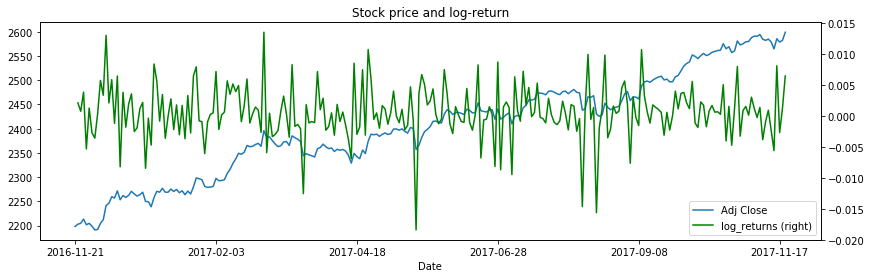

In [4]:
# Import the data
data = pd.read_csv('GSPC.csv')

# Create the log-returns
data = data.assign(log_returns=np.log(data['Adj Close'].values)-np.log(data['Adj Close'].shift(1).values))

# Plot the Adjusted Close prices and log-returns
plt.figure(1)
#handels, labels = ax.get_legend_handles_labels()
ax = data.plot(x='Date', y='Adj Close', figsize=(14,4))
data['log_returns'].plot(secondary_y=True, style='g', legend=True)
ax.get_legend().set_bbox_to_anchor((1,0.2))
plt.title('Stock price and log-return')

Everything seems to be in order. The current price of the stock is 

In [5]:
data.tail(1)

,Date,Open,High,Low,Close,Adj Close,Volume,log_returns
252,2017-11-21,2589.169922,2601.189941,2589.169922,2599.030029,2599.030029,1920976946,0.00652


and the parameters for the closest in the money Call option are $V=\$37.50$ and $K=\$2595.00$. The standard deviation of the historical log-returns, $s$, serves as an estimator for the standard deviation of the stock price, which according to $(42)$ is of the form $\sigma\sqrt{t}$. The term $\sigma$ can be estimated with $s/\sqrt{t}$, and since the historical volatility is calculated from daily log-returns while the quantity of interest is annual volatility, $t$ is one over the number of trading days in a year, taken here to be $252$. The standard error of this estimate is $\sigma_h/\sqrt{2(n-1)}$. With these, and $r=5.215\%$, the historical and implied volatilities can be determined:

In [6]:
# sigma_h is historical volatility
# r is the risk free rate
# sigma_i is the volatility of the stock
# T is the time to maturity in years
# S_0 is the current price of the stock
# K is the stricke price of the option
# V is the observed option price

r = 0.05215
T = 43/252   # 43 days to contract maturity
S_0 = 2599.03
K = 2595.00
V = 37.50

# Calculating the historical volatility from the last 52 days
sigma_h = np.std(np.array(data['log_returns'][200:]))*np.sqrt(252)

# And calculating the implied volatility

sigma_i = e_sigmaImplied(r, sigma_h, T, S_0, K, V)

print(" Historical volatility is", sigma_h, "with standard error", sigma_h/np.sqrt(2*250), "| Implied volatility is:", sigma_i)

 Historical volatility is 0.0504487001559 with standard error 0.0022561344585 | Implied volatility is: 0.0500439569418


Next the option price will be calculated both by Monte Carlo simulation as well as with the closed form solution with historical and implied volatilities. The Monte Carlo simulations will be done with multiple different simulation step numbers in order to investigate the effect it has on the accuracy.

In [7]:
# MC_price_h is the option price calculated with MC and historical volatility
# MC_price_i is the option price calculated with MC and implied volatility
# n is the number of simulation steps in the MC simulation
# BS_price_h is the option price calculated with BS and historical volatility
# BS_price_i is the option price calculated with BS and implied volatility

# Calculate first the option price with Black-Scholes solution
BS_price_h = B_S(sigma_h, r, T, S_0, K)
BS_price_i = B_S(sigma_i, r, T, S_0, K) # For showing that implied volatility was calculated correctly

print("Black-Scholes solution with historical volatility:", BS_price_h)
print("And Black-Scholes solution with sigma_i is of course:", BS_price_i)

Black-Scholes solution with historical volatility: 37.6519127852
And Black-Scholes solution with sigma_i is of course: 37.5000003829


In [9]:
# prices_h is a list of prices calculated with historical volatility with different simulation steps
# prices_i is a list of prices calculated wth implied volatlility with different simulation steps
# computation_time is list of the computation times of the MC routine with different simulation steps, calculated once 

prices_h = []   
prices_i = []
computation_time = []

# Simulations 

for i in range(0,1000000,5000):
    
    if i>0: 
        
        # With historical volatility
        start = time() # Starting the timer
        option1 = europeanOption(i, r, sigma_h, T, S_0, K)
        option1.mcSimulation()
        #V_h, P, S = eMC_optionsBasic(i, r, sigma_h, T, S_0, K)  # Calculate price with MC
        prices_h.append(option1.optionPrice())                               # Save price
        computation_time.append(time()-start)                    # Save Calculation time
        
        # With implied volatility
        #V_i, P, S = eMC_optionsBasic(i, r, sigma_i, T, S_0, K)
        option2 = europeanOption(i, r, sigma_i, T, S_0, K)
        option2.mcSimulation()
        prices_i.append(option2.optionPrice())     

Next lets plot the simulation results and compare them to the calculated results and also plot how the simulated price converges to the calculated price:

Since the historical volatility calculated is slightly higher, the calculated price is higher as well.

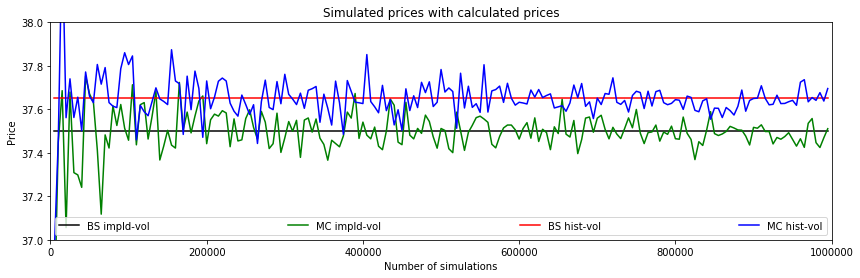

In [10]:
# Valirables to be used in plotting the comparison of simulated prices and calculated prices
x = [i for i in range(5000, 1000000, 5000)]
bsh = [BS_price_h for i in range(199)]
bsi = [BS_price_i for i in range(199)]

# The plot
plt.figure(2)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulations')
plt.ylabel('Price')
plt.axis([0,1000000,37.0,38.0])
plt.plot(x,bsi,'k',label='BS impld-vol')
plt.plot(x,prices_i,'g', label='MC impld-vol')
plt.plot(x,bsh,'r', label='BS hist-vol')
plt.plot(x,prices_h,'b',label='MC hist-vol')
plt.title('Simulated prices with calculated prices')
plt.legend(loc='lower center', mode='expand', ncol=4)

Text(0.5,1,'Convergence of the simulated price to the calculated price')

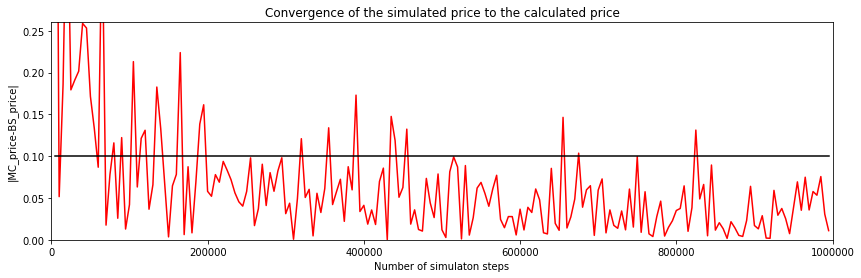

In [11]:
# Absolute value of the difference between calculated price and simulated prices
diff = np.absolute(np.array(prices_i)-bsi)

# Plot of the convergence of simulated price to calculated price
plt.figure(3)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulaton steps')
plt.ylabel('|MC_price-BS_price|')
plt.axis([0,1000000,0,0.26])
plt.plot(x,diff,'r', x, [0.10 for i in range(199)], 'k')
plt.title('Convergence of the simulated price to the calculated price')

Simulation time is also of great interest, so it will be also plotted against the number of simulation steps:

Text(0.5,1,'Simulation time with different number of steps')

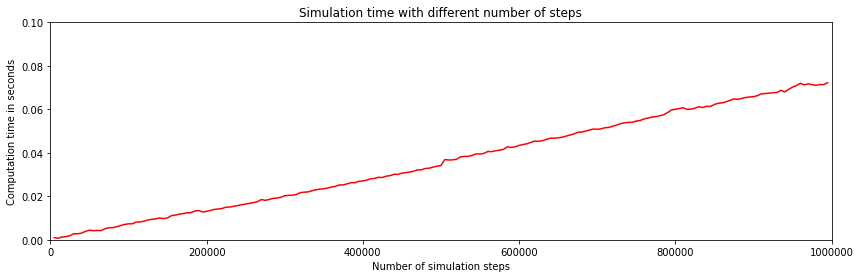

In [12]:
# Plotting the simulation time vs simulation steps
plt.figure(4)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulation steps')
plt.ylabel('Computation time in seconds')
plt.axis([0,1000000,0,0.10])
plt.plot(x, computation_time, 'r')
plt.title('Simulation time with different number of steps')

Depending on which volatility is used, the simulated prices converge to the corresponding Black-Scholes solution. After around $600000$ simulation steps the estimated price stays pretty well within ten cents from the realized price. The computation time seems to grow pretty much linearly with the simulation steps, being less than one tenth of a second at $1000000$ steps. This kind of computational speed can be reach with Python using NumPy vectors and vector operations, using traditional for loops would produce computation times one order of magnitude larger:

In [13]:
# Option pricing algorithm with a foor loop

start = time()
x_1,x_2,x_3 = (r-0.5*np.power(sigma_i,2))*T, sigma_i*np.sqrt(T), np.exp(-r*T)
P = []
for i in range(1000000):
    
    S = S_0*np.exp(x_1+x_2*np.random.randn())
    P.append(x_3*np.maximum(S-K,0))

Price = np.mean(P)
print("Calculated price:", Price)
print("Computation time with a for loop, 1000000 steps:", time()-start)


Calculated price: 37.5402099488
Computation time with a for loop, 1000000 steps: 5.115227460861206


The wastefulness of crude Monte Carlo simulation in this case can be seen from the large standard deviation leading to a large standard error of the estimator and the amount of zeros in simulated option prices:

In [14]:
option = europeanOption(600000, r, sigma_i, T, S_0, K)
option.mcSimulation()
print('Standard error of the simulated prices:', option.error())
print('Number of zero prices simulated in 600000 steps:',option.zeros(), 'or', '%.2f' % ((option.zeros()/600000)*100), 'precent.')

Standard error of the simulated prices: 0.0521464931503
Number of zero prices simulated in 600000 steps: 186131 or 31.02 precent.


This leads to slower convergence to the actual price and an inaccuracy that seems quite high. In order to try and reduce the error and get a more accurate estimate of the price as well as cut down on simulation steps with faster convergence, the method of control variates is explored next.

### Control variates 

In using control variates method, not only is the process $Y$, the process under study, simulated but also another process $X$ for which $\mathbb{E}[X]$ is known. Each simulation step $Y_i$ in this scheme becomes

\begin{alignat}{1}
Y_i \Longrightarrow Y_i(c) = Y_i-c\left(X_i-\mathbb{E}[X]\right),
\end{alignat}

where $c$ is a fixed parameter to be optimized. Note that the sample mean still produces and unbiased estimate for $\mathbb{E}[Y]$:

\begin{alignat}{1}
\mathbb{E}[\bar{Y}(c)] = \mathbb{E}\left[\dfrac{1}{n}\sum_{i=1}^n\left(Y_i-c\left(X_i-\mathbb{E}[X]\right)\right)\right] = \mathbb{E}[\bar{Y}-c\left(\bar{X}-\mathbb{E}[X]\right) = \mathbb{E}[Y].
\end{alignat}

The new $Y_i(c)$ have variance

\begin{alignat}{1}
\text{Var}[Y_i(c)] = \text{Var}[Y_i-c(X_i-\mathbb{E}[X])] = \text{Var}[Y_i]-2c\text{Cov}[Y_i,X_i]+c^2\text{Var}[X_i] \equiv \sigma^2(c).
\end{alignat}

While the original estimator had standard error $\sigma/\sqrt{n}$, where $\sigma=\sqrt{\text{Var}[Y]}$ was the standard deviation of $Y_i$'s, the new estimator has standard error $\sigma(c)/\sqrt{n}$ which is a function of $c$. The minimum of $\sigma^2(c)$ is at

\begin{alignat}{2}
&\dfrac{\partial \sigma^2(c)}{\partial c} &&= -2\text{Cov}[Y,X]+2c\text{Var}[X] = 0 \Leftrightarrow c = \dfrac{\text{Cov}[Y,X]}{\text{Var}[X]}.
\end{alignat}

Looking at the ratio of $\sigma^2$ and $\sigma^2(c)$, a condition for reduction in variance can be derived

\begin{alignat}{1}
\dfrac{\sigma^2(c)}{\sigma^2} = \dfrac{\text{Var}[Y]-2\frac{\text{Cov}[Y,X]}{\text{Var}[X]}+\left(\frac{\text{Cov}[Y,X]}{\text{Var}[X]}\right)^2\text{Var}[X]}{\text{Var}[Y]} = 1-\left(\dfrac{\text{Cov}[Y,X]}{\text{Var}[Y]\text{Var}[X]}\right)^2 = 1-\rho_{YX}^2,
\end{alignat}

where $\rho_{YX}$ is the correlation between $Y$ and $X$. A few important things can be deduced immediately. The larger the correlation between $Y$ and $X$ the smaller the standard error of the control variate estimator. Assuming the calculations for a single simulation step are constant, the same standard error achieved for the control variate in $n$ steps takes $n/(1-\rho_{YX}^2)$ steps with the original estimator. Usually Var$[Y]$ and the correlation between $Y$ and $X$ are not known, so an estimate $\hat{c}$ has to be used:

\begin{alignat}{1}
\hat{c} = \dfrac{\sum_{i=1}^n(Y_i-\bar{Y})(X_i-\bar{X})}{\sum_{i=1}^n(X_i-\bar{X})^2}.
\end{alignat}

Equation $(57)$ is immediately recognized as the slope of a regression line through points $(X_i, Y_i)$. A second observation is also to be made: replacing $c$ with $\hat{c}$, the control variate estimator is no longer unbiased: the bias $\mathbb{B} = \mathbb{E}[Y]-\mathbb{E}[\bar{Y}(\hat{c})] = \mathbb{E}[\hat{c}(\bar{X}-\mathbb{E}[X])$ is only zero if the $\hat{c}$ used is independent of $\bar{X}$. This can be achieved by estimating $\hat{c}$ from a different sample than $\bar{X}$ and would thus require additional computational resources. For large sample sizes this is not necessary as the bias can be shown to be $\mathcal{O}(1/n)$. In addition to this, since least squares estimates are unbiased, if the regression of $Y_i$'s on $X_i$'s is linear, the control variate estimator is unbiased.

The choice of a good control variate depends on the system at hand. For European options maybe the most obvious control variate is the underlying asset. This would work since in absence of arbitrage appropriately discounted asset prices are martingales; for a current asset price $S(t=0)$, exp$(-rT)S(t)$ is a martingale and $\mathbb{E}[\text{exp}(-rT)S(T)]=S(0)$. Next the above ideas are implemented using the underlying asset as a control variate variable for the option price.

Now the estimator for $V(S(0),0)$ becomes 

\begin{alignat}{1}
\bar{V}(\hat{c})=\dfrac{1}{n}\sum_{i=1}^n\left((e^{-rT}\text{max}(S_i(T)-K,0)-\hat{c}(S_i(T)-e^{-eT}S(0))\right).
\end{alignat}

In order to estimate $\hat{c}$, first vectors $Y_i=e^{-rT}\text{max}(S_i(T)-K,0)$ and $X_i=S_i(T)$ are generated and then $\hat{c}$ will be determined from $(57)$. After this the price and its standard error are calculated.

The algorithm for utilizing the control variate goes as follows:

- Do the crude simulation, get vectors $\mathbf{s}$ and $\mathbf{cp}$ for asset prices and option prices 
- Calculate $\hat{c}$ by substituting $\mathbf{s}$ and $\mathbf{cp}$ and their means to (57) (use dot products for sums)
- Calculate the new option prices $\mathbf{P}=\mathbf{cp}-\hat{c}(\mathbf{s}-\text{exp}(rT)S(0))$
- Calculate the estimated option value $V$ as the mean of $\mathbf{P}$: $V=\text{mean}(\mathbf{P})$


In [15]:
class controlvariateEuropean:
    
    def __init__(self,n,r,sigma,T,S_0,K):
        self.n, self.r, self.sigma, self.T, self.S0, self.K = n, r, sigma, T, S_0, K
        
    def cv_mcSimulation(self):
        # Method for calculating the option prices now with control variate
        
        # Run the normal MC 
        crudeMC = europeanOption(self.n, self.r, self.sigma, self.T, self.S0, self.K)
        crudeMC.mcSimulation()
        
        # The required quantities from the crude MC
        self.s = crudeMC.S
        self.cp = crudeMC.P 
        
        # Calculate c-hat
        self.c_hat = (np.dot(self.cp-np.mean(self.cp), self.s-np.mean(self.s)))/(np.dot(self.s-np.mean(self.s),
                                                                                      self.s-np.mean(self.s)))
        
        # Simulate the prices using control variate
        self.P = self.cp-self.c_hat*(self.s-np.exp(self.r*self.T)*self.S0)
        
    def error(self):
        # Return standard error
        self.COV = np.cov(self.cp, self.s, ddof=1) # Covariance matrix
        return np.sqrt((self.COV[0][0]-2*self.c_hat*self.COV[0][1]+np.power(self.c_hat,2)*self.COV[1][1])/(self.n))
                                    
    def optionPrice(self):
        # Return estimated price for the option
        return np.mean(self.P)
    
    def crudeCalculations(self):
        # Return price estimated with crude MC and the standard error
        return np.mean(self.cp), np.std(self.cp,ddof=1)/np.sqrt(self.n) 

Doing the same price convergence plot as above and looking at how the standard error behaves as a function of simulation steps, the following plots are obtained:

In [16]:
prices_crude = []   
prices_cv = []
se_crude = []    # Standard error of the crude MC
se_cv = []       # Standard error of control variate MC

# Simulations 

for i in range(0,1000000,5000):
    
    if i>0: 
         
        # Doing the simulation
        option = controlvariateEuropean(i,r,sigma_i,T,S_0,K)
        option.cv_mcSimulation()
        crude_price, crude_error = option.crudeCalculations()
        prices_crude.append(crude_price)
        prices_cv.append(option.optionPrice())
        se_crude.append(crude_error)
        se_cv.append(option.error())

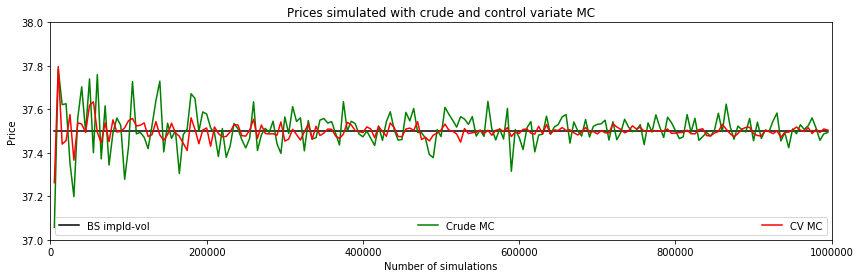

In [17]:
# Plots

# Valirables to be used in plotting the comparison of simulated prices and calculated prices
x = [i for i in range(5000, 1000000, 5000)]
bsi = [BS_price_i for i in range(199)]

# The plot
plt.figure(6)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulations')
plt.ylabel('Price')
plt.axis([0,1000000,37.0,38.0])
plt.plot(x,bsi,'k',label='BS impld-vol')
plt.plot(x,prices_crude,'g', label='Crude MC')
plt.plot(x,prices_cv,'r',label='CV MC')
plt.title('Prices simulated with crude and control variate MC')
plt.legend(loc='lower center', mode='expand', ncol=3)
        

Text(0.5,1,'Convergence of the simulated prices to the calculated price')

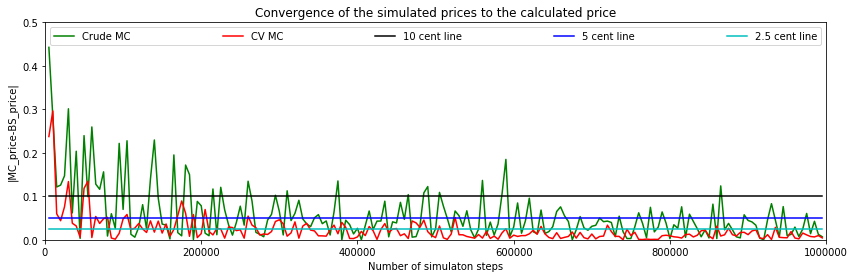

In [18]:
# Absolute value of the difference between calculated price and simulated prices
diff = np.absolute(np.array(prices_crude)-bsi)
diff_cv = np.absolute(np.array(prices_cv)-bsi)

# Plot of the convergence of simulated price to calculated price
plt.figure(7)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulaton steps')
plt.ylabel('|MC_price-BS_price|')
plt.axis([0,1000000,0,0.5])
plt.plot(x,diff,'g', label='Crude MC')
plt.plot(x, diff_cv, 'r', label='CV MC')
plt.plot(x, [0.10 for i in range(199)], 'k', label='10 cent line')
plt.plot(x, [0.05 for i in range(199)], 'b', label='5 cent line')
plt.plot(x, [0.025 for i in range(199)], 'c', label='2.5 cent line')
plt.legend(loc='upper center', mode='expand', ncol=5)
plt.title('Convergence of the simulated prices to the calculated price')

and the standard error of these two estimators can be compared by plotting them against the simulation steps:

Text(0.5,1,'Comparison of standard errors as a function of simulation steps')

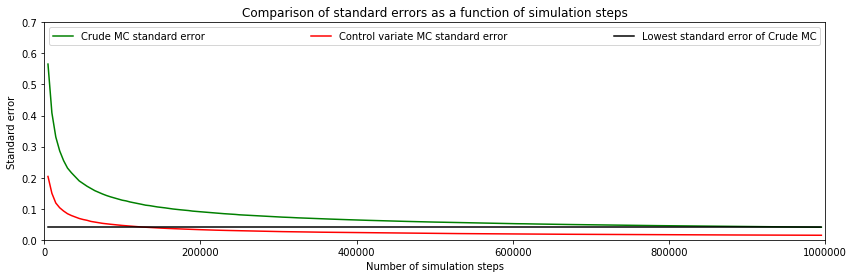

In [19]:
plt.figure(8)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulation steps')
plt.ylabel('Standard error')
plt.axis([0,1000000,0,0.7])
plt.plot(x,se_crude, 'g', label='Crude MC standard error')
plt.plot(x,se_cv, 'r', label='Control variate MC standard error')
plt.plot(x, [se_crude[-1] for i in range(199)], 'k', label='Lowest standard error of Crude MC')
plt.legend(loc='upper center', mode='expand', ncol=3)
plt.title('Comparison of standard errors as a function of simulation steps')

One thing becomes very clear, using the underlying asset as a control variate reduces the standard error substantially faster. The new price converges to about $0.07\%$ of the correct price in the amount of steps the original estimator converged to about $0.27\%$ and the standard error that the original estimator reached in $1000000$ steps is reached in less than $200000$ steps by the new estimator. A scatter plot and histogram can be used to see why this is so:

In [20]:
# Run the simulaition for 500000 times
option = controlvariateEuropean(500000,r,sigma_i,T,S_0,K)
option.cv_mcSimulation()
P = option.cp
S = option.s

Text(0.5,1,'Scatterplot of simulated option prices and simulated asset prices')

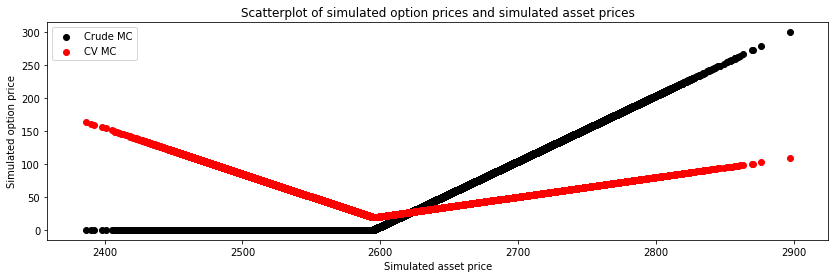

In [21]:
# Scatterplot of the simulated option prices vs simulated asset prices
plt.figure(9)
plt.figure(figsize=(14,4))
plt.xlabel('Simulated asset price')
plt.ylabel('Simulated option price')
plt.scatter(option.s, option.cp, c='k', label='Crude MC')
plt.scatter(option.s, option.P, c='r', label='CV MC')
plt.legend(loc='upper left')
plt.title("Scatterplot of simulated option prices and simulated asset prices")

Text(0.5,1,'Histogram of simulated option prices')

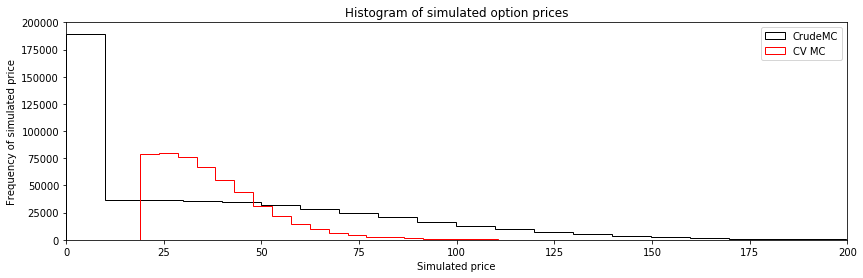

In [22]:
# Histogram of the simulated prices
plt.figure(10)
plt.figure(figsize=(14,4))
plt.xlabel('Simulated price')
plt.ylabel('Frequency of simulated price')
plt.axis([0,200,0,200000])
_ = plt.hist(option.cp, bins=30, color='k', histtype='step', label='CrudeMC')
_ = plt.hist(option.P, bins=30, color='r', histtype='step', label='CV MC')
plt.legend(loc='upper right')
plt.title('Histogram of simulated option prices')

From the scatter plot one can see that using the control variate method, no zeros are actually simulated, and the histogram shows how while big bulk of the simulated prices using crude MC are zeros, majority of the simulated prices using control variate estimator are around the expected value of the option. These serve as nice graphical presentations on how the control variate method improves the estimate.

In the next chapter these methods and results will be used in dealing with Asian style options. There the big difference is that the option prices are path dependent, and hence the calculations a little bit more involved, and being able to reduce simulation steps while gaining more accuracy is valuable.

## Asian options

Perhaps the simplest path dependent option is the Asian style option, the payoff depending on the arithmetic average of the underlying asset price during the lifetime of the option or some other preset time. Compared to the European option, this adds some computational complexity as the former can be thought of as depending only on beginning and end prices of the underlying asset and does not require any evaluations between the option purchase time and expiration.

The main difference in evaluating the Asian option compared to the European is simulation of the path of $(17)$ from $0$ to $T$ in through intermediate time steps $t_i$ and calculating the mean value of the underlying asset on that path $\bar{S}$ for every simulated option price. The path can be simulated either by simulating a geometric Brownian motion or by discretization of $(10)$ using the standard Euler-Maruyama scheme. Since the former method does not introduce discretization error, it is the preferred approach, but just for comparison both methods are used. And on top of these, control variates method will also be implemented with a slightly different quantity than above.

### The numerical scheme

Instead of simulating the underlying asset price only at time $t=T$ with known $S(t=0)$ as was done with the European option, now the underlying asset price is simulated on smaller intervals from $t$ to $t+dt$. The most straightforward approach is to simulate a geometric Brownian motion, and since the increments of Brownian motion are independent, it can be done using $(17)$ directly:

\begin{alignat}{1}
S(t+dt) = S(t)\text{exp}\left[\left(r-\dfrac{\sigma^2}{2}\right)(t+dt-t)+\sigma(W(t+dt)-W(t))\right]=S(t)\text{exp}\left[\left(r-\dfrac{\sigma^2}{2}\right)dt+\sigma\sqrt{dt}Z_{t+dt}\right],
\end{alignat}

where $W(t+dt)-W(t)\Rightarrow\sqrt{dt}Z_{t+dt}$ because of $(6)$. The Euler-Maruyama discretization on the other hand is applied to $(10)$, giving the following expression for $S(t+dt)$:

\begin{alignat}{1}
S(t+dt)-S(t) = r(t+dt-t)+\sigma(W(t+dt)-W(t)) \Rightarrow S(t+dt)=S(t)\left(1+rdt+\sigma\sqrt{dt}Z_{t+dt}\right).
\end{alignat}

Convergence of discretization methods is a whole topic of its own, and here it is just stated that it can be shown that if the coefficients $r$ and $\sigma$ are four times differentiable, then the Euler-Maruyama method has weak order of convergence 1. This means that when the time interval is discretized into $n$ pieces of length $dt$, 

\begin{alignat}{1}
\left|\mathbb{E}[f(\hat{S}(ndt)]-\mathbb{E}[f(S(T))]\right| \leq C\cdot dt^1,
\end{alignat}

for some constant $C$ and small enough $dt$ where the function $f$ is four times differentiable and the derivatives are polynomially bounded. 

For control variates method a few processes are considered: the underlying asset $S(T)$, European option, and an option on geometric average of the asset price $\bar{S}_G$, where 

\begin{alignat}{1}
\bar{S}_G = \left(\prod_{i=0}^{n}S(t_i)\right)^{1/n}.
\end{alignat}

The difference in the numerical procedure when simulating the option prices compared to the European scheme is only in the step where the price of the underlying asset is evaluated; in the European option scheme only one value was calculated and then used in simulating the option price where as in simulating the price of an Asian option a path of the underlying asset is simulated and the arithmetic mean calculated. 

Since the existence of an Asian option on the S&P 500 index is unknown to the author, implied volatility will not be calculated. Volatility calculated from data above will be used instead.

The geometric average- option actually has a closed form solution which will be implemented in the control variate scheme. Here it will be presented as is without derivation for now, the author might revisit the subject and derive the following expression:

\begin{alignat}{1}
V_{\bar{S}_G} = e^{-r}\mathbb{E}[\bar{S}_G]\Phi\left(\dfrac{\ln{\frac{\mathbb{E}[\bar{S}_G]}{K}}+\frac{\sigma^2}{6}T}{\frac{\sigma}{\sqrt{3}}\sqrt{T}}\right)-e^{-rT}K\Phi\left(\dfrac{\ln{\frac{\mathbb{E}[\bar{S}_G]}{K}}+\frac{\sigma^2}{6}T}{\frac{\sigma}{\sqrt{3}}\sqrt{T}}-\sigma\sqrt{\dfrac{T}{3}}\right),
\end{alignat}

where the expectation value of the geometric average $\mathbb{E}[\bar{S}_G]=S_0\text{exp}\left(\dfrac{r}{2}-\dfrac{\sigma^2}{12}\right)$.

The mean of the underlying asset is calculated from the beginning of the purchase of the option. The time interval is discretized into $m=1000$ pieces of length $dt=T/1000\approx1.7\cdot10^{-4}$. The algorithm for calculating the crude Asian option price using goes as follows:

-1a- Calculate the m elements of the price path vector $\mathbf{S}$ using the relation $(59)$

-1b- Calculate the m elements of the price path vector $\mathbf{S}$ using the relation $(60)$

-2-  Calculate an element of the option price vector using the mean of $\mathbf{S}$: $\mathbf{P}(i)=\text{exp}(-rT)\text{max}(\bar{\mathbf{S}}-K,0)$

-3- Return to 1, do this n times

-4- Calculate the expected value of the option $V$ as the mean of $\mathbf{P}$

A class for calculating Asian option prices using this is below:

In [23]:
class asianOption:
    # Class for calculating price for the Asian option using crude Monte Carlo
    # n is the number of MC simulation steps
    # m is the number of steps the time interval was discretized to
    # r is the risk free rate
    # sigma is the volatility
    # T is the time to expiration in years
    # S_0 is the current price of the underlying asset
    # K is the strike price of the option
    
    def __init__(self, n, m, r, sigma, T, S_0, K):
        # Constructor
        self.n, self.m, self.r, self.sigma, self.T, self.S0, self.K = n, m, r, sigma, T, S_0, K
        
    def gbmAssetprice(self):
        # Simulate the price path of the underlying asset using (59)
        
        # Calculate for speed
        dt = self.T*1.0/self.m
        x_1,x_2,x_3 = (self.r-0.5*(self.sigma**2))*dt, self.sigma*np.sqrt(dt), np.exp(-self.r*self.T)
        
        self.gbmP = np.zeros(self.n) # Vector of simulated option prices
        self.gbmS = np.zeros(self.n) # Vector of the averages calculated, for later use
        S = np.zeros(self.m)         # Vector of simulated asset prices
        
        for i in range(self.n):
            S[0] = S_0      # First element is the current price
            for j in range(1,self.m):
                S[j] = S[j-1]*np.exp(x_1+x_2*np.random.randn())    # Simulate the path one step at a time
            self.gbmS[i] = np.mean(S)                            # Save the mean price of the path for later
            self.gbmP[i] = x_3*np.maximum(self.gbmS[i]-self.K,0) # Calculate the option price with that path
            
    def emAssetprice(self):
        # Simulate the price path using (60)
        
        # Calculate for speed
        dt = self.T*1.0/self.m
        x_1,x_2,x_3 = (self.r-0.5*(self.sigma**2))*dt, self.sigma*np.sqrt(dt), np.exp(-self.r*self.T)
        
        self.emP = np.zeros(self.n)  # Vector of simulated option prices
        self.emS = np.zeros(self.n)  # Vector of the averages calculated, for later use
        S = np.zeros(self.m)         # Vector of simulated asset prices
        
        for i in range(self.n):
            S[0] = S_0      # First element is the current price
            for j in range(1,self.m):
                S[j] = S[j-1]*(1+self.r*dt+x_2*np.random.randn())  # Simulate the path one step at a time
            self.emS[i] = np.mean(S)                               # Save the mean price of the path for later
            self.emP[i] = x_3*np.maximum(self.emS[i]-self.K,0)     # Calculate the option price with that path
    
    # Define the methods for returning stuff
    
    def gbm_optionPrice(self):
        # Return the expected option price when (59) was used
        return np.mean(self.gbmP)
    
    def em_optionPrice(self):
        # Return the expected option price when (60) was used
        return np.mean(self.emP)
    
    def gbm_error(self):
        # Return the standard error of the estimate when (59) was used
        return np.std(self.gbmP, ddof=1)/np.sqrt(self.n)
    
    def em_error(self):
        # Return the standard error of the estimate when (60) was used
        return np.std(self.emP, ddof=1)/np.sqrt(self.n)
    
    def gbm_zeros(self):
        # Return the number of zeros in simulation when (59) was used
        return sum([1 if i==0 else 0 for i in self.gbmP])
        
    def em_zeros(self):
        # Return the number of zeros in simulation when (60) was used
        return sum([1 if i==0 else 0 for i in self.emP])

One big problem arises immediately: the calculation times are very large. Even with only 1000 Monte Carlo steps the simulation time is quite long.

In [24]:
start = time()
testi = asianOption(1000, 1000, r, sigma_i, T, S_0, K)
testi.gbmAssetprice()
print("Simulation time: ",time()-start)

Simulation time:  2.7259700298309326


A way to get around this is to write the routines with a faster language. Here it is done with Fortran, and the module is wrapped into a python module with F2PY, implemented here with fortranmagic. The module written below contains a subroutine $asian$ that is called from the Python code; it takes in as arguments the number of Monte Carlo steps, number of time steps, the risk free rate, volatility, time to expiration, current value of underlying asset and the strike price. If the indicator has the value 1, then the prices of underlying asset are simulated using $(59)$, if 2 then $(60)$, and if 3 then the geometric average option is simulated for control variate process, and this uses $(60)$; the goal is to show how much better this control variate process is compared to the others and the discretization scheme will be justified below. The subroutine returns a vector for simulated option prices and a vector of means of simulated prices of the underlying asset.

The subroutine $asian$ breaks the simulation into 4 pieces in the simulation steps, performing each piece on a separate core using OpenMP for multithreading. Each thread calls for another subroutine that performs the actual calculations.

### Fortran code

In [25]:
%load_ext fortranmagic

/usr/local/lib/python3.5/dist-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


In [26]:
%%fortran -vv --f90flags="-fopenmp" --extra="-lgomp" --opt='-O3'
module FasianOption
    implicit none
    
    ! Precision of numbers in use
    integer, parameter :: rk=selected_real_kind(10,40)
    integer, parameter :: ik=selected_int_kind(10)
      
    ! Stuff for the random number generator
    !-------------------------------------------------------------------------
    integer,parameter,private :: defaultsd = 4357    ! Default seed       
    integer,parameter,private :: N = 624, N1 = N + 1 ! Period parameters
    integer,dimension(0:N-1),private :: mt      ! Array for the state vector
    integer,private :: mti = N1
    !-------------------------------------------------------------------------
            
contains
    ! Subroutine for Asian call option, calls the MC routine written below this one. 
    ! Returns also a vector of geometric averages for control variates method
    !
    ! Input parameters are:
    ! n        number of monte carlo simulation steps
    ! m        number of time steps for the underlying asset simulation
    ! r        risk free rate
    ! sigma    volatility
    ! T        time to expipration
    ! S_0      current value of underlying asset
    ! K        option strike price
    ! routine  number indicating which underlying asset simulation  
    !
    ! Output parameters are:
    ! P      vector of simulated option prices, dim(n)
    ! S      vector of simulated averages of the underlying asset, dim(n)
    ! P_cv   vector of simulated control variate prices, dim(n)
    
    
    subroutine asian(n, m, r, sigma, T, S_0, K, routine, P, S, P_cv)
        use omp_lib ! OpenMP library
        implicit none
                
        integer, parameter :: rk=selected_real_kind(10,40)
        
        ! Imput parameters
        real(kind=rk), intent(in) :: S_0, r, sigma, T, K
        integer, intent(in) :: n, m, routine
        
        ! Return parameters
        real(kind=rk), intent(out) :: P(n), S(n), P_cv(n)        
        
        ! Other quantitites
        real(kind=rk), allocatable :: P_i(:,:), S_i(:,:), P_icv(:,:)! Arrays for quantities for different cores
        real(kind=rk) :: dt, x_1, x_2, x_3, x_4                 ! Timestep etc..
        integer :: thread_n, c_p, i                 ! Thread number, length of array given to each core etc
        
        c_p = n/4
        dt = T/m
        
        ! Calculate for speed
        x_1 = (r-(0.5d0)*(sigma**2))*dt
        x_2 = sigma*sqrt(dt)
        x_3 = exp(-r*T)
        x_4 = r*dt
            
        call omp_set_num_threads(4)                    ! Set number of threads
        allocate(P_i(c_p,4), S_i(c_p,4), P_icv(c_p,4)) ! Allocate space for the arrays
        
        ! Go parallel
        
        !$omp parallel private(thread_n) 
    
        thread_n = omp_get_thread_num() ! Get thread numbers
    
        if (thread_n==0) then
            call a_mc(c_p, m, S_0, x_1, x_2, x_3, x_4, K, routine, thread_n, P_i(:,1), S_i(:,1), P_icv(:,1))       
        end if
    
        if (thread_n==1) then
            call a_mc(c_p, m, S_0, x_1, x_2, x_3, x_4, K, routine, thread_n, P_i(:,2), S_i(:,2), P_icv(:,2))
        end if
        
        if (thread_n==2) then
            call a_mc(c_p, m, S_0, x_1, x_2, x_3, x_4, K, routine, thread_n, P_i(:,3), S_i(:,3), P_icv(:,3))
        end if
    
        if (thread_n==3) then
            call a_mc(c_p, m, S_0, x_1, x_2, x_3, x_4, K, routine, thread_n, P_i(:,4), S_i(:,4), P_icv(:,4))
        end if   
    
        !$omp end parallel
                      
        ! Piece together the option price vector
        P(1:c_p) = P_i(:,1)
        P(c_p+1:2*c_p) = P_i(:,2)
        P(2*c_p+1:3*c_p) = P_i(:,3)
        P(3*c_p+1:n) = P_i(:,4)
        
        if ((routine==1).or.(routine==2)) then
            ! Piece together the average asset prices vector
            S(1:c_p) = S_i(:,1)
            S(c_p+1:2*c_p) = S_i(:,2)
            S(2*c_p+1:3*c_p) = S_i(:,3)
            S(3*c_p+1:n) = S_i(:,4)
        end if
        
        if (routine==3) then
            ! Piece together the control variate process vector
            P_cv(1:c_p) = P_icv(:,1)
            P_cv(c_p+1:2*c_p) = P_icv(:,2)
            P_cv(2*c_p+1:3*c_p) = P_icv(:,3)
            P_cv(3*c_p+1:n) = P_icv(:,4)
        end if
        
    end subroutine asian
    
    ! Monte Carlo subroutine for Asian Call option calculated using GBM in discretization
    !
    ! Input parameters:
    ! c_p      number of monte carlo steps
    ! m        number of time steps
    ! S_0      present value of underlying asset
    ! x_1      drift term for gbm
    ! x_2      diffusion term
    ! x_3      discount term
    ! x_4      drift term for em
    ! K        option strike price
    ! routine  number indicating which routine to use for underlying asset or for geometric average
    ! thread_n thread number for seeding the random number generator 
    !
    ! Input/Output terms:
    !
    ! P_i    array of simulated option prices, dim(c_p)
    ! S_i    array of simulated asset prices, dim(c_p)
    ! P_icv  array of simulated control variate prices , dim(c_p)
    
    subroutine a_mc(c_p, m, S_0, x_1, x_2, x_3, x_4, K, routine, thread_n, P_i, S_i, P_icv)
        implicit none
        
        integer, parameter :: rk=selected_real_kind(10,40)
        
        ! Input parameters
        integer, intent(in) :: c_p, m, routine, thread_n
        real(kind=rk), intent(in) :: S_0, x_1, x_2, x_3, x_4, K
        
        ! Output parameters
        real(kind=rk), intent(inout) :: P_i(c_p), S_i(c_p), P_icv(c_p)
                
        ! Other parameters                
        integer :: i, j
        real(kind=rk), allocatable :: S(:)
        real(kind=rk) :: S_bar, Z
                
        allocate(S(m))
        
        ! RN generator seed 
        call sgrnd(getseed(info=thread_n+1))
        
        ! Do the actual MC siulations
        ! if routine is gbm
        if (routine==1) then
            do i=1,c_p
                S(1) = S_0
                do j=2,m
                    Z = gaussrnd()
                    S(j) = S(j-1)*exp(x_1+x_2*Z)
                end do
                S_bar = sum(S)/m
                S_i(i) = S_bar
                P_i(i) = x_3*max(S_i(i)-K, 0d0)
            end do
        ! if routine is em
        else if (routine==2) then
            do i=1,c_p
                S(1) = S_0
                do j=2,m
                    Z = gaussrnd()
                    S(j) = S(j-1)*(1+x_4+x_2*Z)
                end do
                S_bar = sum(S)/m
                S_i(i) = S_bar
                P_i(i) = x_3*max(S_i(i)-K,0d0)
            end do
        ! if routine is for geometric average cv then the crude is 
        ! simulated simultaneously
        else if (routine==3) then
            do i=1,c_p
                S(1) = S_0
                do j=2,m
                    Z = gaussrnd()
                    S(j) = S(j-1)*(1+x_4+x_2*Z)
                end do
                S_bar = sum(log(S))/m  ! The products get quite large, so lets use sum of logarithms...
                P_icv(i) = x_3*max(exp(S_bar)-K, 0d0)  ! ...and take e^ in order to get the geometric average
                S_bar = sum(S)/m
                P_i(i) = x_3*max(S_bar-K,0d0)
            end do
        end if
                    
    end subroutine a_mc
        
    
!------------------------------------------------------------------------------------------------  
!------------------------------------------------------------------------------------------------   
    !-----------------------------------------!
    ! Mersenne Twister random number generator!
    !-----------------------------------------!
    !---------------------------------------------------------------!
    ! Initialization subroutine                                     !
    !---------------------------------------------------------------!

    subroutine sgrnd(seed)
        implicit none
        ! Setting initial seeds to mt[N] using the generator Line 25 of Table 1 in
        ! [KNUTH 1981, The Art of Computer Programming Vol. 2 (2nd Ed.), pp102]
        integer, intent(in) :: seed    
        mt(0) = iand(seed,-1)
        do mti=1,N-1
           mt(mti) = iand(69069 * mt(mti-1),-1)
        enddo
        return
    end subroutine sgrnd
    
    !---------------------------------------------------------------!
    ! Random number generator: [0,1[                                !                                                              !
    !---------------------------------------------------------------!

    function grnd()
        implicit none
        
        integer, parameter :: rk=selected_real_kind(10,40)
        integer, parameter :: ik=selected_int_kind(10)
                                    
                                    
        real(kind=rk) :: grnd    
        ! Period parameters
        integer, parameter :: M = 397, MATA  = -1727483681 ! constant vector a
        integer, parameter :: LMASK =  2147483647          ! least significant r bits
        integer, parameter :: UMASK = -LMASK - 1           ! most significant w-r bits
        ! Tempering parameters
        integer, parameter :: TMASKB= -1658038656, TMASKC= -272236544    
        integer,save :: mag01(0:1)=[0,MATA] ! mag01(x) = x * MATA for x=0,1
    
        integer :: kk,y

        if (mti>=N) then               ! generate N words at one time
            if (mti==N+1) then          ! if sgrnd() has not been called,
                call sgrnd( defaultsd ) ! a default initial seed is used
            endif
            do kk=0,N-M-1
                y=ior(iand(mt(kk),UMASK),iand(mt(kk+1),LMASK))
                mt(kk)=ieor(ieor(mt(kk+M),ishft(y,-1)),mag01(iand(y,1)))
            enddo
            do kk=N-M,N-2
                y=ior(iand(mt(kk),UMASK),iand(mt(kk+1),LMASK))
                mt(kk)=ieor(ieor(mt(kk+(M-N)),ishft(y,-1)),mag01(iand(y,1)))
            enddo
            y=ior(iand(mt(N-1),UMASK),iand(mt(0),LMASK))
            mt(N-1)=ieor(ieor(mt(M-1),ishft(y,-1)),mag01(iand(y,1)))
            mti = 0
        endif
    
        y=mt(mti)
        mti = mti + 1 
        y=ieor(y,TSHFTU(y))
        y=ieor(y,iand(TSHFTS(y),TMASKB))
        y=ieor(y,iand(TSHFTT(y),TMASKC))
        y=ieor(y,TSHFTL(y))
    
        if (y<0) then
            grnd=(dble(y)+2.0d0**32)/(2.0d0**32-1.0d0)
        else
            grnd=dble(y)/(2.0d0**32-1.0d0)
        endif
    
        return

    contains

        integer function TSHFTU(y)
        integer,intent(in) :: y
        TSHFTU=ishft(y,-11)
        return
        end function TSHFTU
        integer function TSHFTS(y)
        integer,intent(in) :: y
        TSHFTS=ishft(y,7)
        return
        end function TSHFTS
        integer function TSHFTT(y)
        integer,intent(in) :: y
        TSHFTT=ishft(y,15)
        return
        end function TSHFTT
        integer function TSHFTL(y)
        integer,intent(in) :: y
        TSHFTL=ishft(y,-18)
        return
        end function TSHFTL

    end function grnd
                                    
    !---------------------------------------------------------------!
    ! Integer random number generator [l,j]:                        !
    !---------------------------------------------------------------!

    integer function igrnd(l,h)
        implicit none
        integer,intent(in) :: l,h
        real(kind=rk) :: u,r
        u=grnd()
        r=(h-l+1)*u+l
        igrnd=int(r)
        return
    end function igrnd

    !---------------------------------------------------------------!
    ! Random numbers with normal (0,1 Gaussian) distribution.       !
    !---------------------------------------------------------------!  
  
    function gaussrnd()
        implicit none
        
        integer, parameter :: rk=selected_real_kind(10,40)
        integer, parameter :: ik=selected_int_kind(10)                       
                                    
        real(kind=rk) :: gaussrnd
        real(kind=rk) :: fac,v1,v2,r
        real(kind=rk), save :: gset
        integer, save :: iset=0

        if (iset==0) then ! Create a new RN
            r=100.0
            do while (r>1.0)
                v1 = 2.0*grnd()-1.0
                v2 = 2.0*grnd()-1.0
                r = v1*v1+v2*v2
            end do
            fac = sqrt(-2.0*log(r)/r)
            gset = v1*fac
            gaussrnd = v2*fac
            iset = 1
        else ! Use the 2nd NR from the previous call
            gaussrnd = gset
            iset = 0
        endif
        return
    end function gaussrnd
                                    
    !------------------------------------------------------!
    !  Get the RNG seed from /dev/urandom device.          !
    !------------------------------------------------------!
    
    integer function getseed(info,file)
  
        implicit none
        integer,optional,intent(in) :: info,file
        integer :: t(8),rn,is
        integer,parameter :: LMASK=huge(rn) ! = 0111...111
        integer,parameter :: LUN=676769
        character (len=80) :: rdev0='/dev/urandom',rdev1='/dev/random',rdev
        logical :: openok,readok,printinfo

        openok=.true.
        readok=.true.

        if (present(file)) then
            if (file==0) then
                rdev=rdev0
            else
                rdev=rdev1
            end if
        else
            rdev=rdev0
        end if
        if (present(info)) then
            printinfo=(info/=0)
        else
            printinfo=.false.
        end if

        open(LUN,file=rdev,form='unformatted',access='stream',action='read',iostat=is)
        if (is/=0) then
            openok=.false.
            print *,'open',is
        else
            read(LUN,iostat=is) rn
            if (is/=0) then
                readok=.false.
            end if
        end if
        if (openok) close(LUN)

        if (openok.and.readok) then
            rn=iand(rn,LMASK) ! Make it positive, i.e. zero the leftmost bit
            if (printinfo) write(6,'(a,a,a,i0)') 'Seed from ',trim(rdev),': ',rn
        else
            call date_and_time(values=t)
            rn=t(7)+60*(t(6)+60*(t(5)+24*(t(3)-1+31*(t(2)-1+12*t(1)))))+t(8)
            if (printinfo) write(6,'(a,i12)') 'Seed from time:',rn
        end if

    getseed=rn
    return
  end function getseed
!--------------------------------------------------------------------------------------------
end module FasianOption 

Running...
   /usr/bin/python3 -m numpy.f2py --f90flags="-fopenmp" --opt='-O3' -lgomp -m _fortran_magic_8f25693dad73b1116488ad93049daa71 -c /home/jeskin/.cache/ipython/fortran/_fortran_magic_8f25693dad73b1116488ad93049daa71.f90

Ok. The following fortran objects are ready to use: fasianoption


A new class for calculating not only the crude MC option prices but all the prices using the different control variates processes as well is written next.

In [27]:
class asianOptions:
    # Class for calculating price for the Asian option using crude Monte Carlo
    # n is the number of MC simulation steps
    # m is the number of steps the time interval was discretized to
    # r is the risk free rate
    # sigma is the volatility
    # T is the time to expiration in years
    # S_0 is the current price of the underlying asset
    # K is the strike price of the option
    
    def __init__(self, n, m, r, sigma, T, S_0, K):
        # Constructor
        self.n, self.m, self.r, self.sigma, self.T, self.S0, self.K = n, m, r, sigma, T, S_0, K
        
        # Calculate for speed
        self.x_1 = (self.r-0.5*(self.sigma**2))*self.T
        self.x_2 = self.sigma*np.sqrt(self.T)
        self.x_3 = np.exp(-self.r*self.T)
        
    # Crude MC using (59) for underlying asset simulation
    def gbm_crudeMC(self):
        # Call the Fortran subroutine
        self.P_gbm, self.S_gbm, _ = fasianoption.asian(self.n, self.m, self.r, self.sigma, self.T, self.S0, self.K, 1)
            
    # Crude MC using (60) for underlying asset simulation
    def em_crudeMC(self):
        # Call the Fortran subroutine
        self.P_em, self.S_em, _ = fasianoption.asian(self.n, self.m, self.r, self.sigma, self.T, self.S0, self.K, 2)
        
    # Underlying asset and European option as control variates processes
    def cv_AssetE(self):
        
        # Vector of random variables
        N = x_1+x_2*np.random.randn(self.n)
        
        # Simulate stock prices
        self.S_T = self.S0*np.exp(N)
        
        # Simulate the European option prices
        self.P_T = x_3*np.maximum(self.S_T-self.K,0)
        
        # The gbm case for underlying asset
        try:
            # Calculate c-hat
            self.cs_gbm = (np.dot(self.P_gbm-np.mean(self.P_gbm), 
                             self.S_T-np.mean(self.S_T)))/(np.dot(self.S_T-np.mean(self.S_T), 
                                                                  self.S_T-np.mean(self.S_T)))
            # Simulate the option prices using the control variate process
            self.P_cvS_gbm = self.P_gbm-self.cs_gbm*(self.S_T-self.S0*np.exp(self.r-self.T))
        except (NameError, AttributeError):
            pass
        
        # The em case for underlyiong asset
        try:
            # Calcuate c-hat
            self.cs_em = (np.dot(self.P_em-np.mean(self.P_em), 
                            self.S_T-np.mean(self.S_T)))/(np.dot(self.S_T-np.mean(self.S_T), 
                                                                 self.S_T-np.mean(self.S_T)))
            # Simulate the option prices using the control variate process
            self.P_cvS_em = self.P_em-self.cs_em*(self.S_T-self.S0*np.exp(self.r*self.T))
        except (NameError, AttributeError):
            pass
            
        # The gbm case for european option
        try:
            # Calculate c-hat
            self.cp_gbm = (np.dot(self.P_gbm-np.mean(self.P_gbm), 
                             self.P_T-np.mean(self.P_T)))/(np.dot(self.P_T-np.mean(self.P_T), 
                                                                  self.P_T-np.mean(self.P_T)))
            # Simulate the option prices using the control variate process
            self.P_cvP_gbm = self.P_gbm-self.cp_gbm*(self.P_T-B_S(self.sigma, self.r, self.T, self.S0, self.K))
        except (NameError, AttributeError):
            pass
        
        # The em case for european option
        try:
            # Calculate c-hat
            self.cp_em = (np.dot(self.P_em-np.mean(self.P_em), 
                             self.P_T-np.mean(self.P_T)))/(np.dot(self.P_T-np.mean(self.P_T), 
                                                                  self.P_T-np.mean(self.P_T)))
            # Simulate the option prices using the control variate process
            self.P_cvP_em = self.P_em-self.cp_em*(self.P_T-B_S(self.sigma, self.r, self.T, self.S0, self.K))
        except (NameError, AttributeError):
            pass
            
    # Geometric average as control variate process
    def cv_GeoAve(self):
        
        # Define some variables ready
        D1 = (np.log(self.S0/self.K)+(0.5*self.r+(self.sigma**2)/12)*self.T)/(self.sigma*np.sqrt(self.T/3))
        D2 = D1-self.sigma*np.sqrt(T/3)
        
        # Black-Scholes solution for option on geometric average of the underlying asset
        BS_G = self.S0*np.exp((-0.5*self.r-(self.sigma**2)/12)*self.T)*stats.norm.cdf(D1)-np.exp(-self.r*T)*self.K*stats.norm.cdf(D2)
        
        # Calculate the geometric average prices by simulation
        # Call the fortran subroutine
        self.P_G, _, self.P_cvG = fasianoption.asian(self.n, self.m, self.r, self.sigma, self.T, self.S0, self.K, 3)
        
        # The geometric average option only has gbm routine 
        # Calculate c-hat
        self.cg = (np.dot(self.P_G-np.mean(self.P_G), 
                              self.P_cvG-np.mean(self.P_cvG)))/(np.dot(self.P_cvG-np.mean(self.P_cvG), 
                                                                       self.P_cvG-np.mean(self.P_cvG)))
        # Simulate the option prices using the control variate process
        self.P_cgP = self.P_G-self.cg*(self.P_cvG-BS_G)

    # Standard errors
    
    def error_crude(self):
        # Standard error for crude MC 
        y = []
        try:
            y.append(np.std(self.P_gbm, ddof=1)/np.sqrt(self.n))
        except (NameError, AttributeError):
            pass
        try:
            y.append(np.std(self.P_em,ddof=1)/np.sqrt(self.n))
        except (NameError, AttributeError):
            pass
        return y # If both gbm and em are calculated, first element is the error of gbm and second of em
    
    def error_cvAsset(self):
        # Standard error when using underlying asset as CV process
        y = []
        try:
            cov = np.cov(self.P_gbm, self.S_T, ddof=1)
            y.append(np.sqrt((cov[0][0]-2*self.cs_gbm*cov[0][1]+(self.cs_gbm**2)*cov[1][1])/self.n))
        except (NameError, AttributeError):
            pass
        try:
            cov = np.cov(self.P_em, self.S_T, ddof=1)
            y.append(np.sqrt((cov[0][0]-2*self.cs_em*cov[0][1]+(self.cs_em**2)*cov[1][1])/self.n))
        except (NameError, AttributeError):
            pass
        return y # If both gbm and em are calculated, first element is the error of gbm and second of em 
    
    def error_cvEoption(self):
        # Standard error when using European option as CV process
        y = []
        try:
            cov = np.cov(self.P_gbm, self.P_T, ddof=1)
            y.append(np.sqrt((cov[0][0]-2*self.cp_gbm*cov[0][1]+(self.cp_gbm**2)*cov[1][1])/self.n))
        except (NameError, AttributeError):
            pass
        try:
            cov = np.cov(self.P_em, self.P_T, ddof=1)
            y.append(np.sqrt((cov[0][0]-2*self.cp_em*cov[0][1]+(self.cp_em**2)*cov[1][1])/self.n))
        except (NameError, AttributeError):
            pass
        return y # If both gbm and em are calculated, first element is the error of gbm and second of em 
    
    def error_cvGeoAve(self):
        # Standard error when using Geometric average option as CV process
        try:
            cov = np.cov(self.P_G, self.P_cvG, ddof=1)
            return(np.sqrt((cov[0][0]-2*self.cg*cov[0][1]+(self.cg**2)*cov[1][1])/self.n))
        except (NameError, AttributeError):
            pass
        

    # Calculate the option prices
    
    def crude_optionPrice(self):
        # Crude MC 
        V = []
        try:
            V.append(np.mean(self.P_gbm))
        except (NameError, AttributeError):
            pass
        try:
            V.append(np.mean(self.P_em))
        except (NameError, AttributeError):
            pass
        return V  # If both gbm and em are calculated, first element is from gbm and second from em
    
    def asset_cv_optionPrice(self):
        # Option prices using asset as CV
        V = []
        try:
            V.append(np.mean(self.P_cvS_gbm))
        except (NameError, AttributeError):
            pass
        try:
            V.append(np.mean(self.P_cvS_em))
        except (NameError, AttributeError):
            pass
        return V # If both gbm and em are calculated, first element is from gbm and second from em
    
    def eoption_cv_optionPrice(self):
        # Option prices using european option as CV
        V = []
        try:
            V.append(np.mean(self.P_cvP_gbm))
        except (NameError, AttributeError):
            pass
        try:
            V.append(np.mean(self.P_cvP_em))
        except (NameError, AttributeError):
            pass
        return V # If both gbm and em are calculated, first element is from gbm and second from em
    
    def ga_cv_optionPrice(self):
        # Option price using geometric average option as CV
        return(np.mean(self.P_cgP))

The above Fortran module and Python class using it are very comprehensive and allows for proper comparison of methods. The crude simulation can be done either by using either $(59)$ or $(60)$, as can the control variate methods using the underlying asset or European option as control processes. The routine using option on geometric average of the underlying only uses the Euler-Maruyama scheme, this will be justified next. 

First of all, it would be useful to know how the different discretization schemes differ from each other. So lets compare the simulation running times and estimator standard errors for as a function of simulation steps. 

In [29]:
# Lets go from 1000 steps to 100000 steps

gbm_time = []
gbm_error = []
em_time = []
em_error = []

crude_price = []

for i in range(1000, 100001, 1000):
    
    x = asianOptions(i, 1000, r, sigma_i, T, S_0, K)

    # GBM discretization scheme
    start = time()
    x.gbm_crudeMC()
    gbm_time.append(time()-start)

    # EM discretization scheme
    start = time()
    x.em_crudeMC()
    p = x.crude_optionPrice()
    crude_price.append(p[1])
    em_time.append(time()-start)

    errors = x.error_crude()
    gbm_error.append(errors[0])
    em_error.append(errors[1])
    

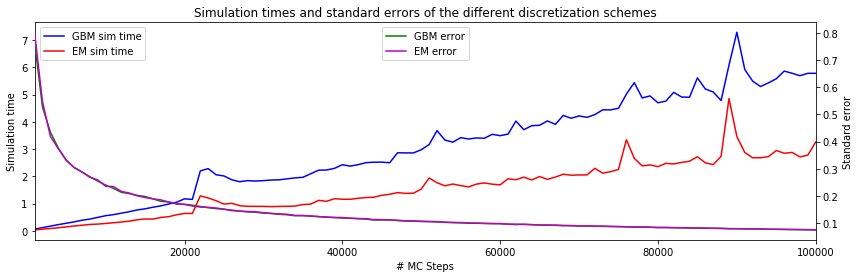

In [38]:
# Plot of how the standard errors and simulations times behave as functions of MC steps
x_axis = [i for i in range(1000,100001, 1000)]

f1 = plt.figure(11, figsize=(14,4))

ax = f1.add_subplot(111, label='Simulation time')
ax2 = f1.add_subplot(111, label='Standard error', frame_on=False)

ax.plot(x_axis, gbm_time, 'b-', label='GBM sim time')
ax.plot(x_axis, em_time, 'r-', label='EM sim time')

ax.set_xlabel('# MC Steps')
ax.set_ylabel('Simulation time')
ax.set_xlim(x_axis[0], x_axis[-1])

ax2.plot(x_axis, gbm_error, 'g-', label='GBM error')
ax2.plot(x_axis, em_error, 'm-', label='EM error')

ax2.set_xticks([])
ax2.yaxis.tick_right()
ax2.set_ylabel('Standard error')
ax2.yaxis.set_label_position('right')
ax2.set_xlim(x_axis[0], x_axis[-1])

ax.set_title('Simulation times and standard errors of the different discretization schemes')
ax.legend(loc='upper left')
ax2.legend(loc='upper center')

Quite surprisingly, the standard errors do not differ noticeably from each other where as there is a substantial difference in simulation times. The difference in times demonstrates how evaluating the exponential function is much more expensive than calculating simple products. Since the errors are so close to each other and it is much cheaper to use the Euler-Maruyama scheme, the way the geometric average as control variate process is written in the Fortran routine is justified. 

Next lets see how the simulation times and standard errors using the different control variate processes compare to each other using the faster discretization scheme. Since the control variates estimate is done pretty much simultaneously for the underlying asset and European option, they both use the same crude MC routine call, only one time measurement is done for them. Also, the calculated option prices will be recorded for comparison.  

In [32]:
# Again, lets go from 1000 steps to 100000 steps

# Simulation times
ao_time = []
ga_time = []

# Standard errors
asset_error = []
eoption_error = []
ga_error = []

# Option prices
asset_cv_price = []
eoption_cv_price = []
ga_cv_price = []

for i in range(1000, 100001, 1000):
    
    x = asianOptions(i, 1000, r, sigma_i, T, S_0, K)

    # Asset and European option as CV
    start = time()
    x.em_crudeMC()
    x.cv_AssetE()
    ao_time.append(time()-start)
    
    asset_error.append(x.error_cvAsset())
    eoption_error.append(x.error_cvEoption())
    
    asset_cv_price.append(x.asset_cv_optionPrice())
    eoption_cv_price.append(x.eoption_cv_optionPrice())
    
    # Geometric average option as CV
    start = time()
    x.cv_GeoAve()
    ga_time.append(time()-start)
    
    ga_error.append(x.error_cvGeoAve())
    ga_cv_price.append(x.ga_cv_optionPrice())

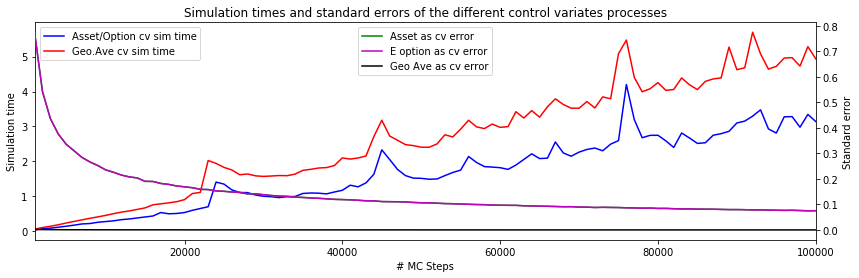

In [39]:
# Plot of how the standard errors and simulations times behave as functions of MC steps
x_axis = [i for i in range(1000,100001, 1000)]

f1 = plt.figure(12, figsize=(14,4))

ax = f1.add_subplot(111, label='Simulation time')
ax2 = f1.add_subplot(111, label='Standard error', frame_on=False)

ax.plot(x_axis, ao_time, 'b-', label='Asset/Option cv sim time')
ax.plot(x_axis, ga_time, 'r-', label='Geo.Ave cv sim time')

ax.set_xlabel('# MC Steps')
ax.set_ylabel('Simulation time')
ax.set_xlim(x_axis[0], x_axis[-1])

ax2.plot(x_axis, asset_error, 'g-', label='Asset as cv error')
ax2.plot(x_axis, eoption_error, 'm-', label='E option as cv error')
ax2.plot(x_axis, ga_error, 'k-', label='Geo Ave as cv error')

ax2.set_xticks([])
ax2.yaxis.tick_right()
ax2.set_ylabel('Standard error')
ax2.yaxis.set_label_position('right')
ax2.set_xlim(x_axis[0], x_axis[-1])

ax.set_title('Simulation times and standard errors of the different control variates processes')
ax.legend(loc='upper left')
ax2.legend(loc='upper center')

Text(0.5,1,'Option price estimated with all methods')

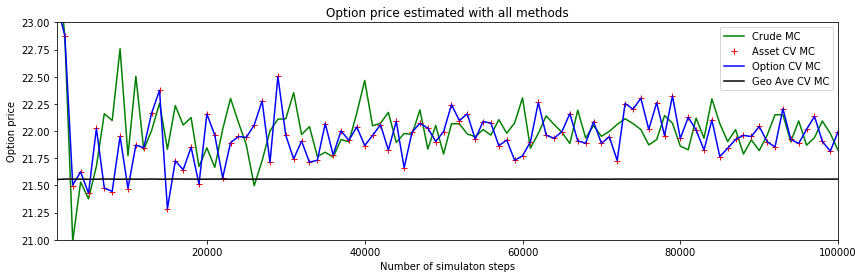

In [37]:
# Plot for the option prices

plt.figure(13)
plt.figure(figsize=(14,4))
plt.xlabel('Number of simulaton steps')
plt.ylabel('Option price')
plt.axis([x_axis[0], x_axis[-1], 21, 23])
plt.plot(x_axis, crude_price,'g-', label='Crude MC')
plt.plot(x_axis, asset_cv_price, 'r+', label='Asset CV MC')
plt.plot(x_axis, eoption_cv_price, 'b-', label='Option CV MC')
plt.plot(x_axis, ga_cv_price, 'k-', label='Geo Ave CV MC')
plt.legend(loc='upper right', ncol=1)
plt.title('Option price estimated with all methods')

The huge advantage of using the option on geometric average of the underlying as a control variates process is blatantly clear. The standard error is an order of magnitude smaller than with the other control variate processes, and variation in simulated prices as a function of simulation steps is so small compared to the crude Monte Carlo and other control variates processes, that the line above looks completely straight. The reason for these huge differences was hinted at above during the discussion on control variates: the bigger the correlation between the simulated process and control variate process, the bigger the reduction in standard error. Simulation time grew faster with the geometric average control variate, but this is to be expected since each simulation step had double the calculations.

For illustrative purposes, the correlation between the simulated Asian option prices and geometric average- option prices will next be calculated and scatterplot drawn for visualization to really drive the idea home: 

In [42]:
# Do the simulations with 50000 steps, for Geo Ave that's more than enough and for the others the error 
# isn't that large anymore
x = asianOptions(50000, 1000, r, sigma_i, T, S_0, K)
x.em_crudeMC()
x.cv_AssetE()
x.cv_GeoAve()

Text(0.5,1,'Asian option price vs geometric average- option price with correlation 0.999995770758')

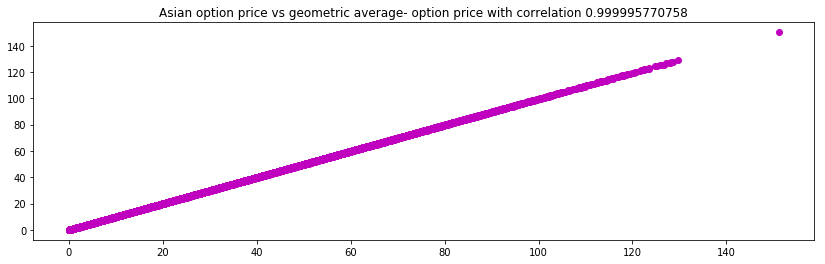

In [47]:
# Calculate the correlation
cor = np.corrcoef(x.P_G, x.P_cvG)

# Scatterplot
plt.figure(14)
plt.figure(figsize=(14,4))
plt.scatter(x.P_G, x.P_cvG, c='m')
plt.title('Asian option price vs geometric average- option price with correlation '+str(cor[0][1]))

## Final thoughts

A fairly simple application of the Monte Carlo method was demonstrated with a straight forward method for improving accuracy and efficiency. The goal was not to create methods for evaluating options in practice, the European option has a closed form solution and the author has not yet figured out where Asian options are traded, but to develop and illustrate some basic methods that can be used in more realistic settings, e.g. in pricing American options. The control variates method is by no means the only variance reduction method, but it can be very effective compared to its simplicity. These tools will be used later in some smaller but more complicated projects.

The author will revisit this project at times to possibly correct some errors. 

Here is the full copyright/author list of the Mersenne Twister random number generator for Fortran that was used, although only part of the code was copied:

In [51]:
%%fortran

! $Id: mtfort90.f90 209 2012-11-12 09:26:46Z aakurone $

!-----------------------------------------------------------------!
!                                                                 !
!                                                                 !
! Module 'mtmod' for Mersenne twister random numbers.             !
!                                                                 !
! Public functions and subroutines:                               !
!                                                                 !
! sgrnd(seed)     initialize RNG (subroutine)                     !
! grnd()          double RN [0,1[ (double precision function)     !
! gaussrnd()      Gaussian RN (mean=0, std=1) (double precision   !
!                 function)                                       !
! igrnd(l,h)      integer RN in [l,h] (limits included)           !
!                 (integer function)                              !
!                                                                 !
! mtsave(f,forma) save RNG state                                  !
! mtget(f,forma)  restore RNG state                               !
!                 (overloaded subroutines)                        !
!                 f=string  : save/restore to/from file           !
!                 f=integer : save/restore to/from Fortran unit   !
!                 forma='U' or 'u' : read/write unformatted,      !
!                 else formatted                                  !
!                                                                 !
! Usage example:                                                  !
!                                                                 !
!    use mtdefs, only : rk                                        !
!       ! NOTE: 'rk' is the real number kind                      !
!       ! defined in module mtdefs (see above).                   !
!       ! Alternatively (see the definitions in the               !
!       ! beginning of the module) you can define the constant as !
!       ! integer,parameter :: rk=selected_real_kind(10,40)       !
!    ...                                                          !
!    use mtmod                                                    !
!    ...                                                          !
!    integer :: seed,i                                            !
!    real(rk) :: x,g                                              !
!    ...                                                          !
!    [ seed=getseed() ]                                           !
!    call sgrnd(seed)                                             !
!    x=grnd()                                                     !
!    g=gaussrnd()                                                 !
!    i=igrnd(0,100)                                               !
!    ...                                                          !
!                                                                 !
!-----------------------------------------------------------------!
!                                                                 !
! Obtained from                                                   !
! http://www.math.sci.hiroshima-u.ac.jp/~m-mat/MT/VERSIONS/\      !
! FORTRAN/mtfort90.f                                              !
!                                                                 !
! Changed real(8) to use selected_real_kind in module defs        !
! (file defs.f90, or defined locally as a constant, see below)    !
! and added 'implicit none' to all routines.                      !
!                                                                 !
!   A.Kuronen, April 2007                                         !
!                                                                 !
! Added igrnd(): integer random number function. A.Kuronen, 2009  !
! Added gaussrnd(): Gaussian random number. A.Kuronen, 2010       !
! Set most module variables private. A.Kuronen, 2010              !
! Function getseed(): seed from /dev/urandom, A.Kuronen, 2014     !
!                                                                 !
!-----------------------------------------------------------------!
!
! Fortran translation by Hiroshi Takano.  Jan. 13, 1999.
!
!   genrand()      -> double precision function grnd()
!   sgenrand(seed) -> subroutine sgrnd(seed)
!                     integer seed
!
! This program uses the following non-standard intrinsics.
!   ishft(i,n): If n>0, shifts bits in i by n positions to left.
!               If n<0, shifts bits in i by n positions to right.
!   iand (i,j): Performs logical AND on corresponding bits of i and j.
!   ior  (i,j): Performs inclusive OR on corresponding bits of i and j.
!   ieor (i,j): Performs exclusive OR on corresponding bits of i and j.
!
!----------------------------------------------------------------------------
!
! Fortran version rewritten as an F90 module and mt state saving and getting
! subroutines added by Richard Woloshyn. (rwww@triumf.ca). June 30, 1999
!
!----------------------------------------------------------------------------
!
! A C-program for MT19937: Real number version
!   genrand() generates one pseudorandom real number (double)
! which is uniformly distributed on [0,1]-interval, for each
! call. sgenrand(seed) set initial values to the working area
! of 624 words. Before genrand(), sgenrand(seed) must be
! called once. (seed is any 32-bit integer except for 0).
! Integer generator is obtained by modifying two lines.
!   Coded by Takuji Nishimura, considering the suggestions by
! Topher Cooper and Marc Rieffel in July-Aug. 1997.
!
! This library is free software; you can redistribute it and/or
! modify it under the terms of the GNU Library General Public
! License as published by the Free Software Foundation; either
! version 2 of the License, or (at your option) any later
! version.
! This library is distributed in the hope that it will be useful,
! but WITHOUT ANY WARRANTY; without even the implied warranty of
! MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
! See the GNU Library General Public License for more details.
! You should have received a copy of the GNU Library General
! Public License along with this library; if not, write to the
! Free Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA
! 02111-1307  USA
!
! Copyright (C) 1997 Makoto Matsumoto and Takuji Nishimura.
! When you use this, send an email to: matumoto@math.keio.ac.jp
! with an appropriate reference to your work.
!
!----------------------------------------------------------------------------
                                 
!---------------------------------------------------------------!
  !                                                               !
  ! Integer random number generator:                              !
  ! return a random integer between in [l,h]                      !
  ! (boundaries l and h included)                                 !
  !                                                               !
  ! A.Kuronen, 2009                                               !
  !                                                               !
  !---------------------------------------------------------------!

  !---------------------------------------------------------------!
  !                                                               !
  ! Random numbers with normal (Gaussian) distribution.           !
  ! Mean is 0 and standard deviation is 1                         !
  ! See W.H.Press et al., Numerical Recipes 1st ed., page 203     !
  !                                                               !
  ! A.Kuronen, 2009                                               !
  !                                                               !
  !---------------------------------------------------------------!

!------------------------------------------------------!
  !                                                      !
  !  Get the RNG seed from /dev/urandom device.          !
  !                                                      !
  !  In order to get positive seed the most              !
  !  significant bit in the number read from the         !
  !  device is cleared (by anding it with LMASK).        !
  !                                                      !
  !  NOTE: Routine uses the default integer type.        !
  !                                                      !
  !  If the device can not be opened or read routine     !
  !  falls back to calculating seed from the current     !
  !  time.                                               !
  !                                                      !
  !  Note that stream i/o is used which is a Fortran     !
  !  2003 feature.                                       !
  !                                                      !
  !                                                      !
  !  Input parameters:                                   !
  !    info : integer, if /=0 print info to stdout       !
  !    file : integer, 0: use /dev/urandom               !
  !                    1: use /dev/random                !
  !                                                      !
  !  Both parameters are optional, so that the simplest  !
  !  way to call the function is 'getseed()'.            !
  !                                                      !
  !                                                      !
  !  Generating a large amount of random numbers using   !
  !  /dev/random may be slow because quality of random   !
  !  bits from this device is guaranteed and system may  !
  !  have to wait while enough 'entropy' is collected    !
  !  from network traffic, keyboard etc.                 !
  !                                                      !
  !                                                      !
  !  A.Kuronen, antti.kuronen@helsinki.fi, 2008-2014     !
  !                                                      !
  !------------------------------------------------------!

RuntimeError: f2py failed, see output